In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
# Configuration de la visualisation
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
class TradingAnalyzer:
    """
    Classe pour analyser les performances du bot de trading crypto
    """
    def __init__(self, crypto_prices_path, positions_path, initial_capital=100.0):
        """
        Initialisation de l'analyseur avec les chemins des fichiers de données
        Args:
            crypto_prices_path (str): Chemin vers le fichier CSV des prix crypto
            positions_path (str): Chemin vers le fichier CSV des positions
            initial_capital (float): Capital initial, par défaut 100.0
        """
        self.crypto_prices_path = crypto_prices_path
        self.positions_path = positions_path
        self.crypto_prices = None
        self.positions = None
        self.initial_capital = initial_capital  # Stockage du capital initial passé en paramètre
        # Charger les données
        self.load_data()
        
    def load_data(self):
        """Charger les données des fichiers CSV"""
        try:
            # Charger les prix des cryptos
            self.crypto_prices = pd.read_csv(self.crypto_prices_path)
            print(f"Données de prix chargées : {len(self.crypto_prices)} enregistrements")
            
            # Convertir les colonnes pertinentes en numériques
            for col in self.crypto_prices.columns:
                if col.startswith('Variation_') or col == 'Total_Variation' or col == 'RSI' or col == 'Volatility_Ratio' or col == 'Volume_Change':
                    self.crypto_prices[col] = pd.to_numeric(self.crypto_prices[col], errors='coerce')
            
            # Charger les positions
            self.positions = pd.read_csv(self.positions_path)
            print(f"Données de positions chargées : {len(self.positions)} positions")
            
            # Convertir les colonnes numériques
            numeric_cols = ['Entry_Price', 'Position_Size', 'Position_Size_Percent', 
                           'Entry_Fees', 'Exit_Price', 'Exit_Fees', 'Profit_Loss', 
                           'Profit_Loss_Net', 'Remaining_Capital', 'RSI', 'Volatility_Ratio',
                           'Volume_Variation']
            
            for col in numeric_cols:
                if col in self.positions.columns:
                    self.positions[col] = pd.to_numeric(self.positions[col], errors='coerce')
                    
            # Convertir les dates
            if 'Heure' in self.positions.columns:
                self.positions['Heure'] = pd.to_datetime(self.positions['Heure'], errors='coerce')
            if 'Heure_Sortie' in self.positions.columns:
                self.positions['Heure_Sortie'] = pd.to_datetime(self.positions['Heure_Sortie'], errors='coerce')
                
            # Calculer la durée des positions
            if 'Heure' in self.positions.columns and 'Heure_Sortie' in self.positions.columns:
                self.positions['Duree_Minutes'] = (self.positions['Heure_Sortie'] - self.positions['Heure']).dt.total_seconds() / 60
                
            return True
        except Exception as e:
            print(f"Erreur lors du chargement des données: {e}")
            return False
    
    def summary_stats(self):
        """Afficher les statistiques de performance globales"""
        if self.positions is None:
            print("Pas de données de positions disponibles")
            return
        
        # Filtrer les positions fermées
        closed_positions = self.positions.dropna(subset=['Profit_Loss_Net'])
        
        # Calculer les statistiques
        total_positions = len(self.positions)
        closed_positions_count = len(closed_positions)
        open_positions_count = total_positions - closed_positions_count
        
        total_profit = closed_positions['Profit_Loss'].sum()
        total_profit_net = closed_positions['Profit_Loss_Net'].sum()
        total_fees = closed_positions['Entry_Fees'].sum() + closed_positions['Exit_Fees'].sum()
        
        winning_positions = closed_positions[closed_positions['Profit_Loss_Net'] > 0]
        losing_positions = closed_positions[closed_positions['Profit_Loss_Net'] <= 0]
        
        # Affichage des résultats
        print("=== STATISTIQUES GLOBALES ===")
        print(f"Nombre total de positions: {total_positions}")
        print(f"Positions fermées: {closed_positions_count}")
        print(f"Positions ouvertes: {open_positions_count}")
        print(f"\nProfit total brut: {total_profit:.4f}")
        print(f"Profit total net (après frais): {total_profit_net:.4f}")
        print(f"Frais totaux: {total_fees:.4f}")
        print(f"\nProfit moyen par position: {(total_profit / closed_positions_count) if closed_positions_count else 0:.4f}")
        print(f"Profit net moyen par position: {(total_profit_net / closed_positions_count) if closed_positions_count else 0:.4f}")
        print(f"\nNombre de positions gagnantes: {len(winning_positions)}")
        print(f"Nombre de positions perdantes: {len(losing_positions)}")
        print(f"Taux de réussite: {(len(winning_positions) / closed_positions_count) * 100 if closed_positions_count else 0:.2f}%")
        
        # Détail par type de position
        print("\n=== PERFORMANCE PAR TYPE DE POSITION ===")
        position_types = closed_positions['Position_Type_Entry'].unique()
        
        for position_type in position_types:
            positions_of_type = closed_positions[closed_positions['Position_Type_Entry'] == position_type]
            wins = len(positions_of_type[positions_of_type['Profit_Loss_Net'] > 0])
            losses = len(positions_of_type[positions_of_type['Profit_Loss_Net'] <= 0])
            
            print(f"\n{position_type}:")
            print(f"  Nombre: {len(positions_of_type)}")
            print(f"  Profit net total: {positions_of_type['Profit_Loss_Net'].sum():.4f}")
            print(f"  Profit net moyen: {positions_of_type['Profit_Loss_Net'].mean():.4f}")
            print(f"  Gagnantes/Perdantes: {wins}/{losses}")
            print(f"  Taux de réussite: {(wins / len(positions_of_type)) * 100 if len(positions_of_type) else 0:.2f}%")
        
        # Détail par type de sortie
        print("\n=== PERFORMANCE PAR TYPE DE SORTIE ===")
        exit_types = closed_positions['Position_Type_Exit'].unique()
        
        for exit_type in exit_types:
            positions_of_exit = closed_positions[closed_positions['Position_Type_Exit'] == exit_type]
            
            print(f"\n{exit_type}:")
            print(f"  Nombre: {len(positions_of_exit)} ({len(positions_of_exit) / closed_positions_count * 100:.2f}%)")
            print(f"  Profit net total: {positions_of_exit['Profit_Loss_Net'].sum():.4f}")
            print(f"  Profit net moyen: {positions_of_exit['Profit_Loss_Net'].mean():.4f}")
    
    def analyze_capital_evolution(self):
        """Analyser et visualiser l'évolution du capital"""
        if self.positions is None or 'Remaining_Capital' not in self.positions.columns:
            print("Données insuffisantes pour analyser l'évolution du capital")
            return
        
        # Filtrer les lignes avec des données de capital
        capital_data = self.positions.dropna(subset=['Remaining_Capital'])
        if len(capital_data) == 0:
            print("Pas de données de capital disponibles")
            return
        
        # Utiliser le capital initial défini dans la classe
        initial_capital = self.initial_capital
        final_capital = capital_data['Remaining_Capital'].iloc[-1]
        growth = ((final_capital - initial_capital) / initial_capital) * 100
        
        print("=== ÉVOLUTION DU CAPITAL ===")
        print(f"Capital initial: {initial_capital:.2f}")
        print(f"Capital final: {final_capital:.2f}")
        print(f"Croissance: {growth:.2f}%")
        
        # Visualiser l'évolution du capital avec le capital initial correct
        plt.figure(figsize=(14, 8))
        
        # Ajouter une ligne pour le capital initial avant la première position
        all_capitals = [initial_capital]
        all_capitals.extend(capital_data['Remaining_Capital'].tolist())
        
        # Créer une liste d'indices pour l'axe x
        x_values = list(range(len(all_capitals)))
        
        plt.plot(x_values, all_capitals, 'b-', linewidth=2)
        plt.axhline(y=initial_capital, color='r', linestyle='--', label='Capital initial')
        plt.title('Évolution du Capital', fontsize=16)
        plt.xlabel('Nombre de transactions', fontsize=14)
        plt.ylabel('Capital', fontsize=14)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def analyze_profits_distribution(self):
        """Analyser la distribution des profits et pertes"""
        if self.positions is None:
            print("Pas de données de positions disponibles")
            return
        
        # Filtrer les positions fermées
        closed_positions = self.positions.dropna(subset=['Profit_Loss_Net'])
        
        if len(closed_positions) == 0:
            print("Pas de positions fermées à analyser")
            return
        
        # Visualiser la distribution des profits/pertes
        plt.figure(figsize=(14, 8))
        sns.histplot(closed_positions['Profit_Loss_Net'], bins=20, kde=True)
        plt.axvline(x=0, color='r', linestyle='--', label='Seuil de rentabilité')
        plt.title('Distribution des Profits/Pertes', fontsize=16)
        plt.xlabel('Profit/Perte Net', fontsize=14)
        plt.ylabel('Fréquence', fontsize=14)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Visualiser les profits selon le type de position
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='Position_Type_Entry', y='Profit_Loss_Net', data=closed_positions)
        plt.axhline(y=0, color='r', linestyle='--', label='Seuil de rentabilité')
        plt.title('Profits/Pertes par Type de Position', fontsize=16)
        plt.xlabel('Type de Position', fontsize=14)
        plt.ylabel('Profit/Perte Net', fontsize=14)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Visualiser les profits selon le type de sortie
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='Position_Type_Exit', y='Profit_Loss_Net', data=closed_positions)
        plt.axhline(y=0, color='r', linestyle='--', label='Seuil de rentabilité')
        plt.title('Profits/Pertes par Type de Sortie', fontsize=16)
        plt.xlabel('Type de Sortie', fontsize=14)
        plt.ylabel('Profit/Perte Net', fontsize=14)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def analyze_indicators(self):
        """Analyser l'influence des indicateurs sur les performances"""
        if self.positions is None:
            print("Pas de données de positions disponibles")
            return
        
        # Filtrer les positions fermées
        closed_positions = self.positions.dropna(subset=['Profit_Loss_Net'])
        if len(closed_positions) == 0:
            print("Pas de positions fermées à analyser")
            return
        
        # 3.1 Analyse RSI vs Profits (code existant inchangé)
        if 'RSI' in closed_positions.columns:
            plt.figure(figsize=(14, 8))
            plt.scatter(closed_positions['RSI'], closed_positions['Profit_Loss_Net'], alpha=0.6)
            plt.axhline(y=0, color='r', linestyle='--', label='Seuil de rentabilité')
            plt.title('RSI vs Profit/Perte', fontsize=16)
            plt.xlabel('RSI', fontsize=14)
            plt.ylabel('Profit/Perte Net', fontsize=14)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        # 3.2 Analyse des plages de RSI (code existant inchangé)
        plt.figure(figsize=(14, 8))
        # Définir les plages de RSI
        rsi_bins = [0, 30, 40, 50, 60, 70, 100]
        rsi_labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-100']
        closed_positions['RSI_Range'] = pd.cut(closed_positions['RSI'], bins=rsi_bins, labels=rsi_labels)
        
        # Calculer les statistiques par plage
        rsi_stats = closed_positions.groupby('RSI_Range')['Profit_Loss_Net'].agg(['mean', 'count'])
        rsi_stats['win_rate'] = closed_positions.groupby('RSI_Range')['Profit_Loss_Net'].apply(
            lambda x: (x > 0).sum() / len(x) * 100)
        
        # Graphique de la performance moyenne par plage de RSI
        ax = rsi_stats['mean'].plot(kind='bar', figsize=(14, 8), color='skyblue')
        plt.title('Profit Moyen par Plage de RSI', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Profit Moyen', fontsize=14)
        
        # Ajouter les étiquettes de données
        for i, v in enumerate(rsi_stats['mean']):
            ax.text(i, v + 0.01 if v >= 0 else v - 0.05,
                    f"{v:.4f}\n({rsi_stats['count'][i]} pos.)",
                    ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Graphique du taux de réussite par plage de RSI
        plt.figure(figsize=(14, 8))
        ax = rsi_stats['win_rate'].plot(kind='bar', figsize=(14, 8), color='green')
        plt.title('Taux de Réussite par Plage de RSI', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Taux de Réussite (%)', fontsize=14)
        
        # Ajouter les étiquettes de données
        for i, v in enumerate(rsi_stats['win_rate']):
            ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # 3.3 Analyse Volatilité vs Profits (modifié pour utiliser MAX_VOLATILITY_RATIO)
        if 'Volatility_Ratio' in closed_positions.columns:
            plt.figure(figsize=(14, 8))
            plt.scatter(closed_positions['Volatility_Ratio'], closed_positions['Profit_Loss_Net'], alpha=0.6)
            plt.axhline(y=0, color='r', linestyle='--', label='Seuil de rentabilité')
            plt.title('Ratio de Volatilité vs Profit/Perte', fontsize=16)
            plt.xlabel('Ratio de Volatilité', fontsize=14)
            plt.ylabel('Profit/Perte Net', fontsize=14)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        # 3.4 Analyse des plages de volatilité (modifié pour utiliser MAX_VOLATILITY_RATIO et MIN_VOLATILITY_RATIO)
        plt.figure(figsize=(14, 8))
        
        # Récupérer les valeurs de configuration de TradingConfig
        config_max_volatility = 5.0  # Valeur par défaut de MAX_VOLATILITY_RATIO
        config_min_volatility = 2.5  # Valeur par défaut de MIN_VOLATILITY_RATIO
        
        # Définir les plages de volatilité dynamiquement basées sur les valeurs de configuration
        # Augmenter la granularité pour une meilleure analyse et inclure toute la plage jusqu'à MAX_VOLATILITY_RATIO
        vol_step = (config_max_volatility - config_min_volatility) / 5  # Diviser la plage en 5 segments
        
        vol_bins = [0]
        if config_min_volatility > 0.5:
            vol_bins.extend([0.5, 1.0, 1.5, 2.0])
        
        # Ajouter des bins entre MIN_VOLATILITY_RATIO et MAX_VOLATILITY_RATIO
        current_bin = config_min_volatility
        while current_bin < config_max_volatility:
            vol_bins.append(current_bin)
            current_bin += vol_step
        
        # Ajouter la valeur maximale
        vol_bins.append(config_max_volatility)
        
        # Créer les étiquettes de plage
        vol_labels = []
        for i in range(len(vol_bins)-1):
            vol_labels.append(f"{vol_bins[i]:.1f}-{vol_bins[i+1]:.1f}")
        
        # Appliquer les plages aux données
        closed_positions['Volatility_Range'] = pd.cut(
            closed_positions['Volatility_Ratio'], 
            bins=vol_bins, 
            labels=vol_labels,
            include_lowest=True
        )
        
        # Calculer les statistiques par plage
        vol_stats = closed_positions.groupby('Volatility_Range')['Profit_Loss_Net'].agg(['mean', 'count'])
        vol_stats['win_rate'] = closed_positions.groupby('Volatility_Range')['Profit_Loss_Net'].apply(
            lambda x: (x > 0).sum() / len(x) * 100 if len(x) > 0 else 0)
        
        # Graphique de la performance moyenne par plage de volatilité
        ax = vol_stats['mean'].plot(kind='bar', figsize=(14, 8), color='orange')
        plt.title('Profit Moyen par Plage de Volatilité', fontsize=16)
        plt.xlabel('Plage de Volatilité', fontsize=14)
        plt.ylabel('Profit Moyen', fontsize=14)
        
        # Ajouter les étiquettes de données
        for i, v in enumerate(vol_stats['mean']):
            if not pd.isna(v):  # Vérifier que la valeur n'est pas NaN
                ax.text(i, v + 0.01 if v >= 0 else v - 0.05,
                        f"{v:.4f}\n({vol_stats['count'][i]} pos.)",
                        ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Graphique du taux de réussite par plage de volatilité
        plt.figure(figsize=(14, 8))
        ax = vol_stats['win_rate'].plot(kind='bar', figsize=(14, 8), color='purple')
        plt.title('Taux de Réussite par Plage de Volatilité', fontsize=16)
        plt.xlabel('Plage de Volatilité', fontsize=14)
        plt.ylabel('Taux de Réussite (%)', fontsize=14)
        
        # Ajouter les étiquettes de données
        for i, v in enumerate(vol_stats['win_rate']):
            if not pd.isna(v):  # Vérifier que la valeur n'est pas NaN
                ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # 3.5 NOUVELLE PARTIE: Analyse des variations de volume vs Profits
        # Cette section analyse comment les variations de volume influencent la performance des positions
        if 'Volume_Variation' in closed_positions.columns:
            plt.figure(figsize=(14, 8))
            plt.scatter(closed_positions['Volume_Variation'], closed_positions['Profit_Loss_Net'], alpha=0.6)
            plt.axhline(y=0, color='r', linestyle='--', label='Seuil de rentabilité')
            plt.title('Variation de Volume vs Profit/Perte', fontsize=16)
            plt.xlabel('Variation de Volume (%)', fontsize=14)
            plt.ylabel('Profit/Perte Net', fontsize=14)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Analyse des plages de variation de volume
            plt.figure(figsize=(14, 8))
            
            # Définir les plages de variation de volume
            # Utiliser des plages adaptées aux données (0-5%, 5-10%, etc.)
            vol_var_bins = [0, 5, 10, 20, 30, 50, 100]
            vol_var_labels = ['0-5%', '5-10%', '10-20%', '20-30%', '30-50%', '50%+']
            
            closed_positions['Volume_Variation_Range'] = pd.cut(
                closed_positions['Volume_Variation'], 
                bins=vol_var_bins, 
                labels=vol_var_labels,
                include_lowest=True
            )
            
            # Calculer les statistiques par plage
            vol_var_stats = closed_positions.groupby('Volume_Variation_Range')['Profit_Loss_Net'].agg(['mean', 'count'])
            vol_var_stats['win_rate'] = closed_positions.groupby('Volume_Variation_Range')['Profit_Loss_Net'].apply(
                lambda x: (x > 0).sum() / len(x) * 100 if len(x) > 0 else 0)
            
            # Graphique de la performance moyenne par plage de variation de volume
            ax = vol_var_stats['mean'].plot(kind='bar', figsize=(14, 8), color='teal')
            plt.title('Profit Moyen par Plage de Variation de Volume', fontsize=16)
            plt.xlabel('Plage de Variation de Volume', fontsize=14)
            plt.ylabel('Profit Moyen', fontsize=14)
            
            # Ajouter les étiquettes de données
            for i, v in enumerate(vol_var_stats['mean']):
                if not pd.isna(v):  # Vérifier que la valeur n'est pas NaN
                    ax.text(i, v + 0.01 if v >= 0 else v - 0.05,
                            f"{v:.4f}\n({vol_var_stats['count'][i]} pos.)",
                            ha='center', fontsize=10)
            plt.tight_layout()
            plt.show()
            
            # Graphique du taux de réussite par plage de variation de volume
            plt.figure(figsize=(14, 8))
            ax = vol_var_stats['win_rate'].plot(kind='bar', figsize=(14, 8), color='darkgreen')
            plt.title('Taux de Réussite par Plage de Variation de Volume', fontsize=16)
            plt.xlabel('Plage de Variation de Volume', fontsize=14)
            plt.ylabel('Taux de Réussite (%)', fontsize=14)
            
            # Ajouter les étiquettes de données
            for i, v in enumerate(vol_var_stats['win_rate']):
                if not pd.isna(v):  # Vérifier que la valeur n'est pas NaN
                    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
            plt.tight_layout()
            plt.show()
    
    def analyze_variations(self):
        """Analyser l'influence des variations de marché sur les performances"""
        if self.positions is None:
            print("Pas de données de positions disponibles")
            return
        
        # Filtrer les positions fermées
        closed_positions = self.positions.dropna(subset=['Profit_Loss_Net'])
        
        if len(closed_positions) == 0:
            print("Pas de positions fermées à analyser")
            return
        
        # Analyser les variations par tranche
        variation_cols = [col for col in closed_positions.columns if col.startswith('Variation_T')]
        
        if not variation_cols:
            print("Pas de données de variation disponibles")
            return
        
        # Visualiser la relation entre les variations et les profits
        plt.figure(figsize=(18, 12))
        
        for i, col in enumerate(variation_cols + ['Total_Variation']):
            if col in closed_positions.columns:
                plt.subplot(2, 2, i+1)
                plt.scatter(closed_positions[col], closed_positions['Profit_Loss_Net'], alpha=0.6)
                plt.axhline(y=0, color='r', linestyle='--', label='Seuil de rentabilité')
                plt.title(f'{col} vs Profit/Perte', fontsize=14)
                plt.xlabel(col, fontsize=12)
                plt.ylabel('Profit/Perte Net', fontsize=12)
                plt.grid(True)
                plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_combined_indicators(self):
        """Analyser les combinaisons d'indicateurs avec ajout de la variation de volume"""
        if self.positions is None:
            print("Pas de données de positions disponibles")
            return
        
        # Filtrer les positions fermées avec toutes les données nécessaires
        closed_positions = self.positions.dropna(subset=['Profit_Loss_Net', 'RSI', 'Volatility_Ratio', 'Volume_Variation'])
        if len(closed_positions) == 0:
            print("Pas de positions fermées avec données d'indicateurs complètes")
            return
        
        # 4.1 Créer un heatmap RSI vs Volatilité (modifié pour utiliser des plages adaptées aux données)
        plt.figure(figsize=(14, 10))
        
        # Récupérer les valeurs de configuration de TradingConfig
        config_max_volatility = 5.0  # Valeur par défaut de MAX_VOLATILITY_RATIO
        config_min_volatility = 2.5  # Valeur par défaut de MIN_VOLATILITY_RATIO
        
        # Définir les plages de RSI
        rsi_bins = [0, 30, 40, 50, 60, 70, 100]
        rsi_labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-100']
        
        # Définir les plages de volatilité dynamiquement
        vol_bins = [0]
        if config_min_volatility > 0.5:
            vol_bins.extend([0.5, 1.0, 1.5, 2.0])
        
        # Ajouter des bins entre MIN_VOLATILITY_RATIO et MAX_VOLATILITY_RATIO
        vol_step = (config_max_volatility - config_min_volatility) / 3  # Diviser la plage en 3 segments
        current_bin = config_min_volatility
        while current_bin < config_max_volatility:
            vol_bins.append(current_bin)
            current_bin += vol_step
        
        # Ajouter la valeur maximale
        vol_bins.append(config_max_volatility)
        
        # Créer les étiquettes de plage
        vol_labels = []
        for i in range(len(vol_bins)-1):
            vol_labels.append(f"{vol_bins[i]:.1f}-{vol_bins[i+1]:.1f}")
        
        # Définir les plages de variation de volume
        vol_var_bins = [0, 5, 10, 20, 100]
        vol_var_labels = ['0-5%', '5-10%', '10-20%', '20%+']
        
        # Appliquer les plages aux données
        closed_positions['RSI_Range'] = pd.cut(closed_positions['RSI'], bins=rsi_bins, labels=rsi_labels)
        closed_positions['Volatility_Range'] = pd.cut(
            closed_positions['Volatility_Ratio'], 
            bins=vol_bins, 
            labels=vol_labels,
            include_lowest=True
        )
        closed_positions['Volume_Variation_Range'] = pd.cut(
            closed_positions['Volume_Variation'], 
            bins=vol_var_bins, 
            labels=vol_var_labels,
            include_lowest=True
        )
        
        # 4.2 Créer une matrice pivot pour l'analyse RSI vs Volatilité
        pivot_profit = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volatility_Range',
            columns='RSI_Range',
            aggfunc='mean'
        )
        
        pivot_count = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volatility_Range',
            columns='RSI_Range',
            aggfunc='count'
        )
        
        # Heatmap du profit moyen RSI vs Volatilité
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_profit, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
        plt.title('Profit Moyen par Combinaison RSI/Volatilité', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Plage de Volatilité', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Heatmap du nombre de positions RSI vs Volatilité
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_count, annot=True, cmap='Blues', fmt='d')
        plt.title('Nombre de Positions par Combinaison RSI/Volatilité', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Plage de Volatilité', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Calculer le taux de réussite par combinaison RSI vs Volatilité
        def win_rate(x):
            return (x > 0).sum() / len(x) * 100 if len(x) > 0 else 0
        
        pivot_winrate = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volatility_Range',
            columns='RSI_Range',
            aggfunc=win_rate
        )
        
        # Heatmap du taux de réussite RSI vs Volatilité
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_winrate, annot=True, cmap='RdYlGn', vmin=0, vmax=100, fmt='.1f')
        plt.title('Taux de Réussite (%) par Combinaison RSI/Volatilité', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Plage de Volatilité', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # 4.3 NOUVELLE PARTIE: Analyse combinée RSI vs Variation de Volume
        # Matrice pivot pour l'analyse RSI vs Variation de Volume
        pivot_profit_vol = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volume_Variation_Range',
            columns='RSI_Range',
            aggfunc='mean'
        )
        
        pivot_count_vol = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volume_Variation_Range',
            columns='RSI_Range',
            aggfunc='count'
        )
        
        # Heatmap du profit moyen RSI vs Variation de Volume
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_profit_vol, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
        plt.title('Profit Moyen par Combinaison RSI/Variation de Volume', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Variation de Volume', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Heatmap du nombre de positions RSI vs Variation de Volume
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_count_vol, annot=True, cmap='Blues', fmt='d')
        plt.title('Nombre de Positions par Combinaison RSI/Variation de Volume', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Variation de Volume', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Calculer le taux de réussite par combinaison RSI vs Variation de Volume
        pivot_winrate_vol = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volume_Variation_Range',
            columns='RSI_Range',
            aggfunc=win_rate
        )
        
        # Heatmap du taux de réussite RSI vs Variation de Volume
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_winrate_vol, annot=True, cmap='RdYlGn', vmin=0, vmax=100, fmt='.1f')
        plt.title('Taux de Réussite (%) par Combinaison RSI/Variation de Volume', fontsize=16)
        plt.xlabel('Plage de RSI', fontsize=14)
        plt.ylabel('Variation de Volume', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # 4.4 NOUVELLE PARTIE: Analyse combinée Volatilité vs Variation de Volume
        # Matrice pivot pour l'analyse Volatilité vs Variation de Volume
        pivot_profit_vol_vola = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volume_Variation_Range',
            columns='Volatility_Range',
            aggfunc='mean'
        )
        
        pivot_count_vol_vola = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volume_Variation_Range',
            columns='Volatility_Range',
            aggfunc='count'
        )
        
        # Heatmap du profit moyen Volatilité vs Variation de Volume
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_profit_vol_vola, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
        plt.title('Profit Moyen par Combinaison Volatilité/Variation de Volume', fontsize=16)
        plt.xlabel('Plage de Volatilité', fontsize=14)
        plt.ylabel('Variation de Volume', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Heatmap du nombre de positions Volatilité vs Variation de Volume
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_count_vol_vola, annot=True, cmap='Blues', fmt='d')
        plt.title('Nombre de Positions par Combinaison Volatilité/Variation de Volume', fontsize=16)
        plt.xlabel('Plage de Volatilité', fontsize=14)
        plt.ylabel('Variation de Volume', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Calculer le taux de réussite par combinaison Volatilité vs Variation de Volume
        pivot_winrate_vol_vola = closed_positions.pivot_table(
            values='Profit_Loss_Net',
            index='Volume_Variation_Range',
            columns='Volatility_Range',
            aggfunc=win_rate
        )
        
        # Heatmap du taux de réussite Volatilité vs Variation de Volume
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_winrate_vol_vola, annot=True, cmap='RdYlGn', vmin=0, vmax=100, fmt='.1f')
        plt.title('Taux de Réussite (%) par Combinaison Volatilité/Variation de Volume', fontsize=16)
        plt.xlabel('Plage de Volatilité', fontsize=14)
        plt.ylabel('Variation de Volume', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # 4.5 NOUVELLE PARTIE: Analyse 3D combinant RSI, Volatilité et Variation de Volume
        # Création d'une analyse par groupe combinant les trois indicateurs
        
        # Regroupement des données par les trois indicateurs
        combined_groups = closed_positions.groupby(['RSI_Range', 'Volatility_Range', 'Volume_Variation_Range'])
        
        # Calcul des statistiques par groupe combiné
        combined_stats = combined_groups['Profit_Loss_Net'].agg(['mean', 'count'])
        combined_stats['win_rate'] = combined_groups['Profit_Loss_Net'].apply(
            lambda x: (x > 0).sum() / len(x) * 100 if len(x) > 0 else 0
        )
        
        # Réinitialiser l'index pour obtenir une table plate
        combined_stats = combined_stats.reset_index()
        
        # Filtrer les groupes avec au moins 1 position pour éviter le bruit
        filtered_stats = combined_stats[combined_stats['count'] >= 1]
        
        # Tableau des meilleures combinaisons par profit moyen
        best_profit_combinations = filtered_stats.sort_values('mean', ascending=False).head(10)
        
        print("=== TOP 10 COMBINAISONS PAR PROFIT MOYEN ===")
        for i, row in best_profit_combinations.iterrows():
            print(f"RSI: {row['RSI_Range']} | Volatilité: {row['Volatility_Range']} | "
                  f"Variation Volume: {row['Volume_Variation_Range']} | "
                  f"Profit moyen: {row['mean']:.4f} | "
                  f"Positions: {row['count']} | "
                  f"Taux de réussite: {row['win_rate']:.1f}%")
        
        # Tableau des meilleures combinaisons par taux de réussite
        best_winrate_combinations = filtered_stats.sort_values('win_rate', ascending=False).head(10)
        
        print("\n=== TOP 10 COMBINAISONS PAR TAUX DE RÉUSSITE ===")
        for i, row in best_winrate_combinations.iterrows():
            print(f"RSI: {row['RSI_Range']} | Volatilité: {row['Volatility_Range']} | "
                  f"Variation Volume: {row['Volume_Variation_Range']} | "
                  f"Profit moyen: {row['mean']:.4f} | "
                  f"Positions: {row['count']} | "
                  f"Taux de réussite: {row['win_rate']:.1f}%")
        
        # 4.6 BONUS: Visualisation de l'impact des combinaisons d'indicateurs sur les types de position
        
        if 'Position_Type_Entry' in closed_positions.columns:
            # Analyse par type de position pour les combinaisons RSI et Volatilité
            for position_type in closed_positions['Position_Type_Entry'].unique():
                positions_by_type = closed_positions[closed_positions['Position_Type_Entry'] == position_type]
                
                # Vérifier qu'il y a des données pour ce type
                if len(positions_by_type) == 0:
                    continue
                    
                # Créer la matrice pivot pour ce type de position
                pivot_type = positions_by_type.pivot_table(
                    values='Profit_Loss_Net',
                    index='Volatility_Range',
                    columns='RSI_Range',
                    aggfunc='mean'
                )
                
                # Heatmap du profit moyen par type de position
                plt.figure(figsize=(14, 10))
                sns.heatmap(pivot_type, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
                plt.title(f'Profit Moyen pour Positions {position_type} par RSI/Volatilité', fontsize=16)
                plt.xlabel('Plage de RSI', fontsize=14)
                plt.ylabel('Plage de Volatilité', fontsize=14)
                plt.tight_layout()
                plt.show()
                
                # Matrice de taux de réussite
                pivot_winrate_type = positions_by_type.pivot_table(
                    values='Profit_Loss_Net',
                    index='Volatility_Range',
                    columns='RSI_Range',
                    aggfunc=win_rate
                )
                
                # Heatmap du taux de réussite par type de position
                plt.figure(figsize=(14, 10))
                sns.heatmap(pivot_winrate_type, annot=True, cmap='RdYlGn', vmin=0, vmax=100, fmt='.1f')
                plt.title(f'Taux de Réussite (%) pour Positions {position_type} par RSI/Volatilité', fontsize=16)
                plt.xlabel('Plage de RSI', fontsize=14)
                plt.ylabel('Plage de Volatilité', fontsize=14)
                plt.tight_layout()
                plt.show()
    
    def generate_comprehensive_report(self, output_dir='./rapport'):
        """Générer un rapport complet avec toutes les analyses"""
        # Créer le dossier de sortie s'il n'existe pas
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Rapport textuel
        report_path = os.path.join(output_dir, 'rapport_performance.txt')
        with open(report_path, 'w') as f:
            f.write("RAPPORT D'ANALYSE DE PERFORMANCE DU BOT DE TRADING\n")
            f.write("=================================================\n\n")
            f.write(f"Date d'analyse: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            # Ajouter les statistiques globales
            f.write("1. STATISTIQUES GLOBALES\n")
            f.write("------------------------\n")
            # Utiliser une capture de sortie pour rediriger le print vers le fichier
            import io
            from contextlib import redirect_stdout
            
            with io.StringIO() as buf, redirect_stdout(buf):
                self.summary_stats()
                output = buf.getvalue()
            
            f.write(output)
            f.write("\n\n")
            
            # Ajouter les recommandations
            f.write("2. RECOMMANDATIONS\n")
            f.write("-----------------\n")
            f.write("Basées sur l'analyse des données:\n\n")
            
            # Analyser les meilleures combinaisons d'indicateurs pour les recommandations
            closed_positions = self.positions.dropna(subset=['Profit_Loss_Net'])
            
            # Recommandations basées sur le type de sortie
            if 'Position_Type_Exit' in closed_positions.columns:
                exit_stats = closed_positions.groupby('Position_Type_Exit')['Profit_Loss_Net'].mean()
                worst_exit = exit_stats.idxmin()
                f.write(f"1. Optimiser la gestion des sorties '{worst_exit}' qui génèrent un profit moyen de {exit_stats[worst_exit]:.4f}\n")
            
            # Recommandations basées sur la volatilité
            if 'Volatility_Ratio' in closed_positions.columns:
                # Définir les plages de volatilité
                vol_bins = [0, 1.0, 1.5, 2.0, 10.0]
                vol_labels = ['<1.0', '1.0-1.5', '1.5-2.0', '>2.0']
                closed_positions['Volatility_Range'] = pd.cut(closed_positions['Volatility_Ratio'], bins=vol_bins, labels=vol_labels)
                
                vol_stats = closed_positions.groupby('Volatility_Range')['Profit_Loss_Net'].mean()
                best_vol = vol_stats.idxmax()
                f.write(f"2. Favoriser les positions dans les plages de volatilité {best_vol} qui montrent un profit moyen de {vol_stats[best_vol]:.4f}\n")
            
            # Recommandations basées sur le RSI
            if 'RSI' in closed_positions.columns:
                # Définir les plages de RSI
                rsi_bins = [0, 30, 50, 70, 100]
                rsi_labels = ['<30', '30-50', '50-70', '>70']
                closed_positions['RSI_Range'] = pd.cut(closed_positions['RSI'], bins=rsi_bins, labels=rsi_labels)
                
                rsi_stats = closed_positions.groupby('RSI_Range')['Profit_Loss_Net'].mean()
                best_rsi = rsi_stats.idxmax()
                f.write(f"3. Privilégier les entrées dans les plages de RSI {best_rsi} qui montrent un profit moyen de {rsi_stats[best_rsi]:.4f}\n")
            
            # Recommandations générales
            f.write("4. Pour améliorer les performances des positions risquées, ajuster les paramètres de Stop Loss plus proches du prix d'entrée\n")
            f.write("5. Optimiser davantage l'utilisation du trailing stop qui montre un 100% de réussite dans cette série de tests\n")
            
            f.write("\n=== FIN DU RAPPORT ===\n")
        
        print(f"Rapport généré avec succès dans {report_path}")
        
        # Pour l'extension de ce rapport, on pourrait ajouter la génération de graphiques
        # et les sauvegarder dans le dossier output_dir
        
        return report_path

Données de prix chargées : 97648 enregistrements
Données de positions chargées : 21 positions
=== STATISTIQUES GLOBALES ===
Nombre total de positions: 21
Positions fermées: 21
Positions ouvertes: 0

Profit total brut: -0.0642
Profit total net (après frais): -0.8677
Frais totaux: 0.8035

Profit moyen par position: -0.0031
Profit net moyen par position: -0.0413

Nombre de positions gagnantes: 14
Nombre de positions perdantes: 7
Taux de réussite: 66.67%

=== PERFORMANCE PAR TYPE DE POSITION ===

Prudente:
  Nombre: 12
  Profit net total: -0.0340
  Profit net moyen: -0.0028
  Gagnantes/Perdantes: 8/4
  Taux de réussite: 66.67%

Risquée:
  Nombre: 9
  Profit net total: -0.8337
  Profit net moyen: -0.0926
  Gagnantes/Perdantes: 6/3
  Taux de réussite: 66.67%

=== PERFORMANCE PAR TYPE DE SORTIE ===

Trailing_Stop:
  Nombre: 14 (66.67%)
  Profit net total: 1.3980
  Profit net moyen: 0.0999

Stop_Loss:
  Nombre: 6 (28.57%)
  Profit net total: -2.5472
  Profit net moyen: -0.4245

Take_Profit:
  

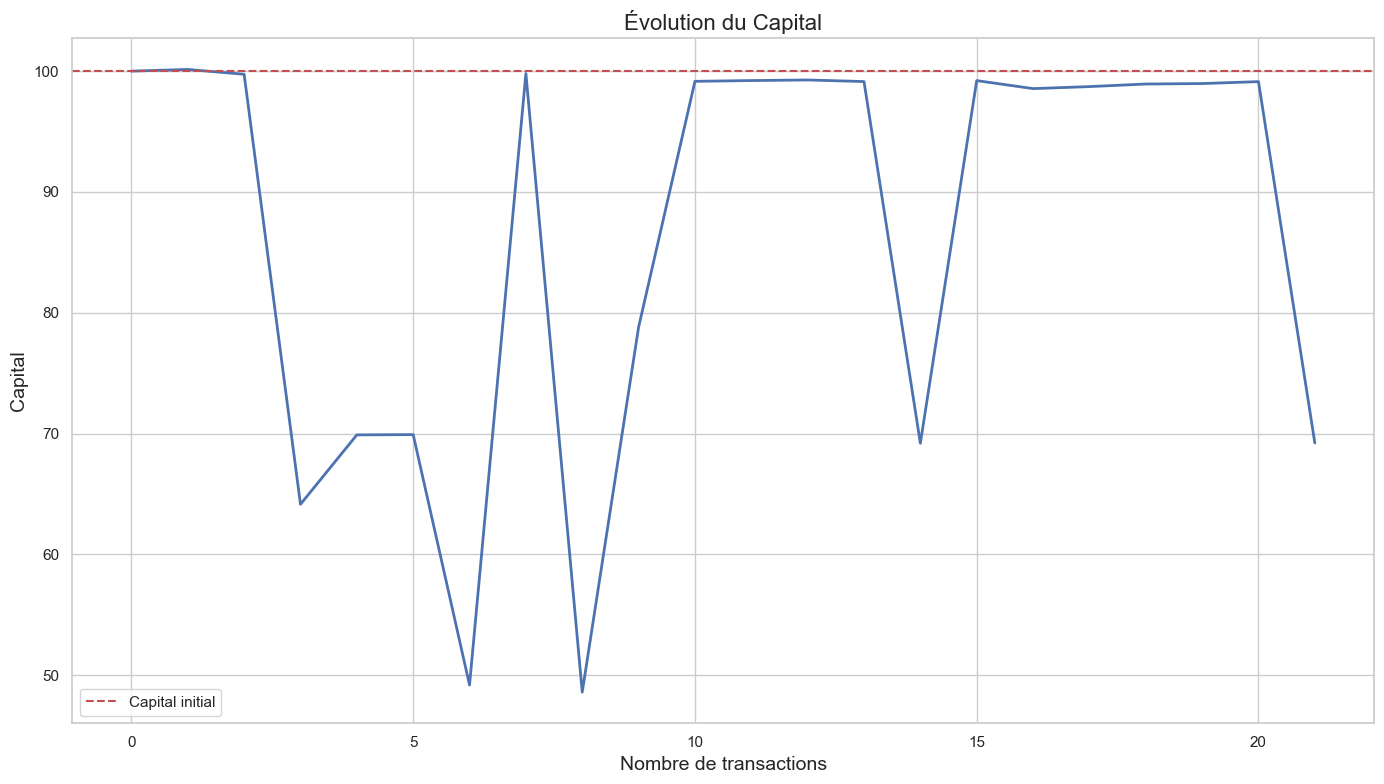

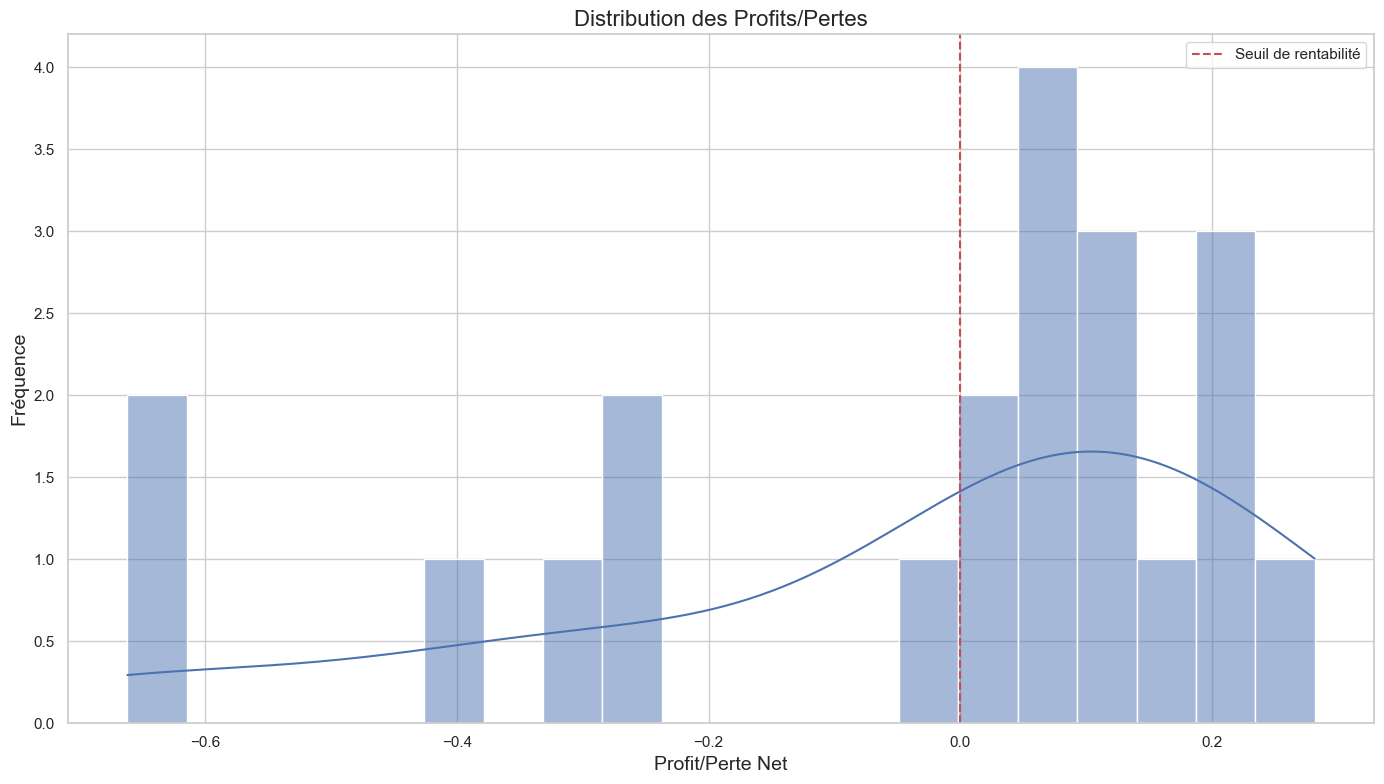

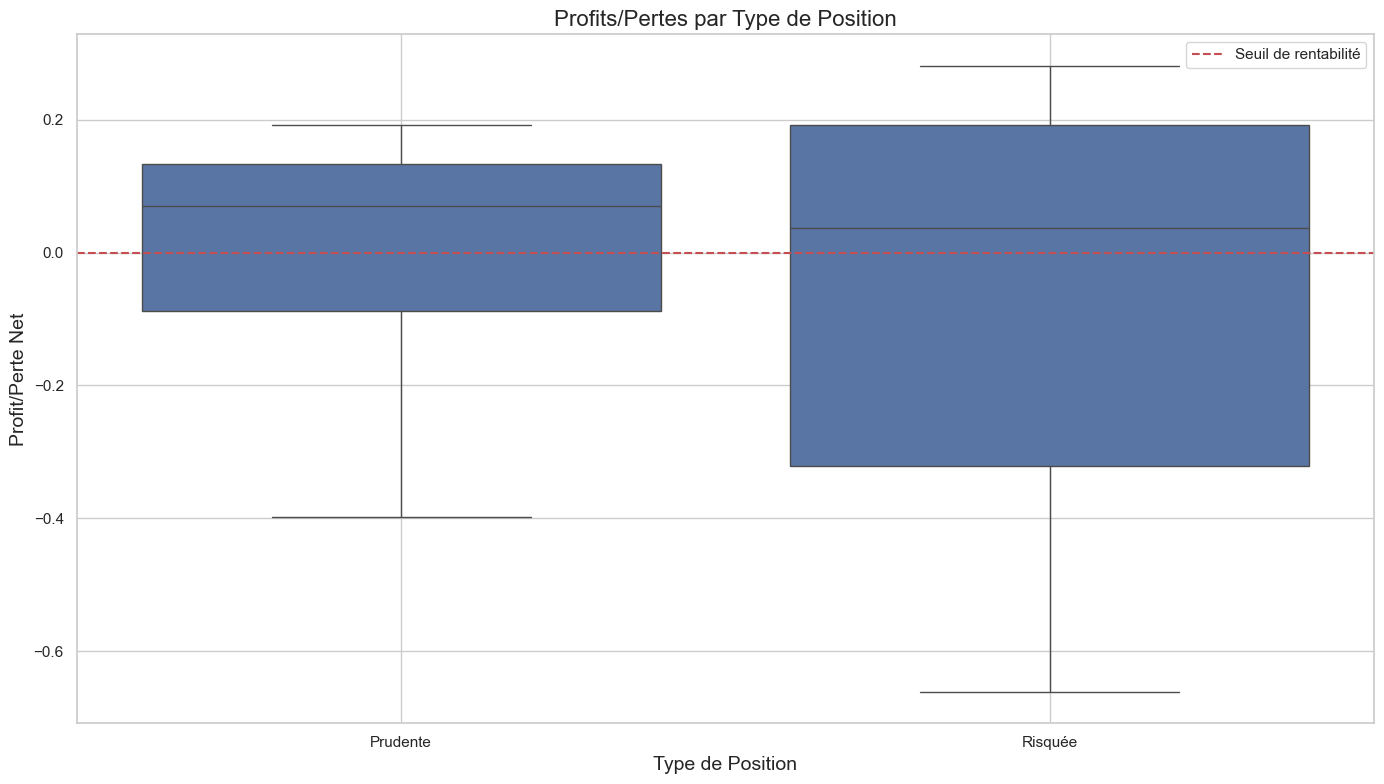

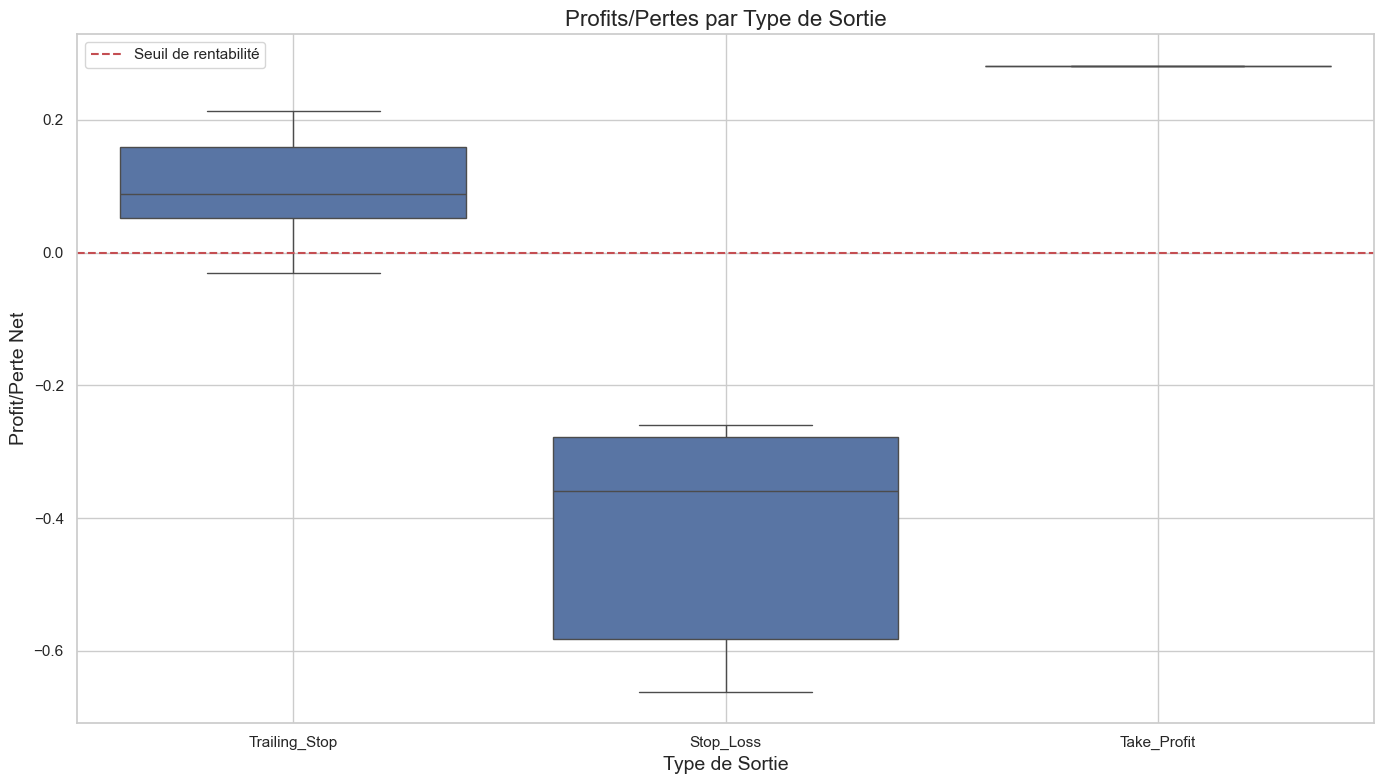

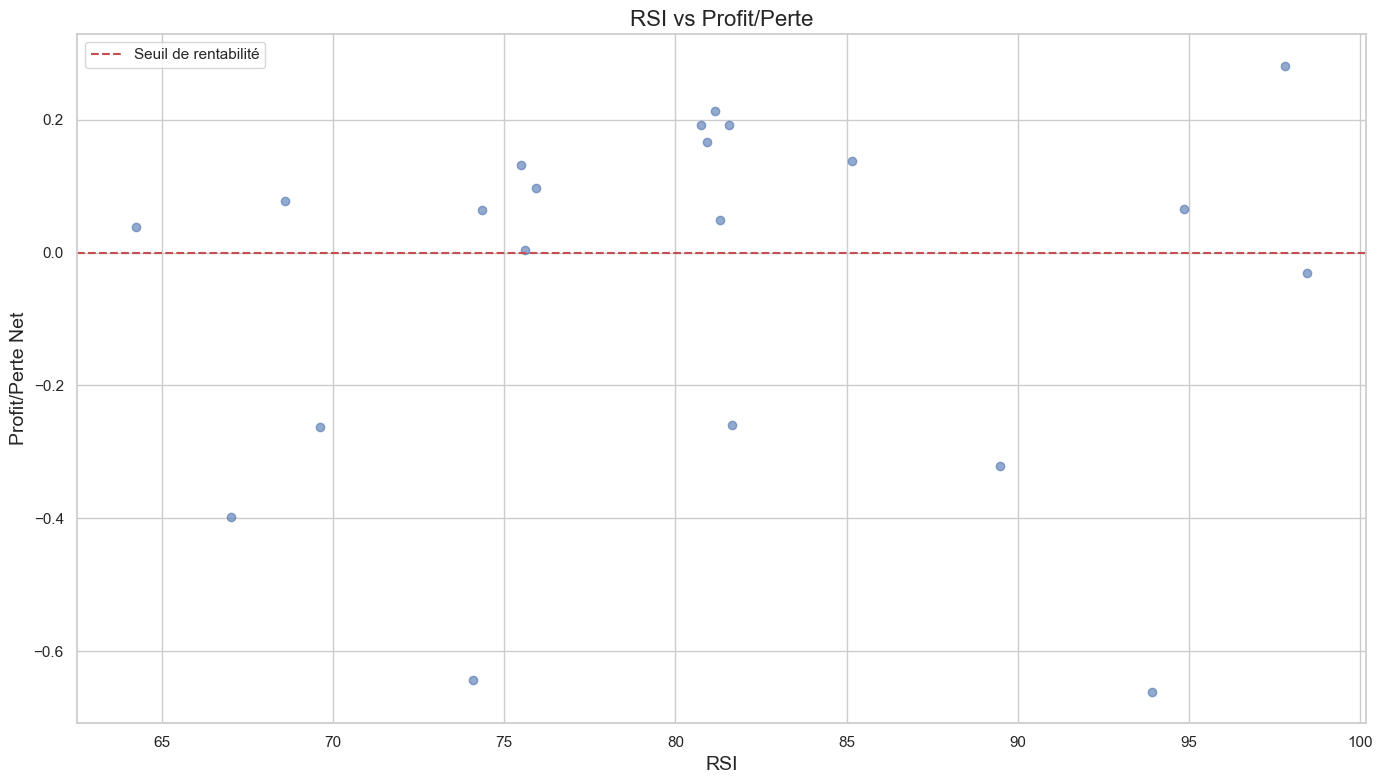

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rsi_stats = closed_positions.groupby('RSI_Range')['Profit_Loss_Net'].agg(['mean', 'count'])
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:250: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rsi_stats['win_rate'] = closed_positions.groupby('RSI_Range')['Profit_Loss_Net'].apply(
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:251: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: (x > 0).sum() / len(x) * 100)
C:\Users\jtive\AppData\Local\Temp\ip

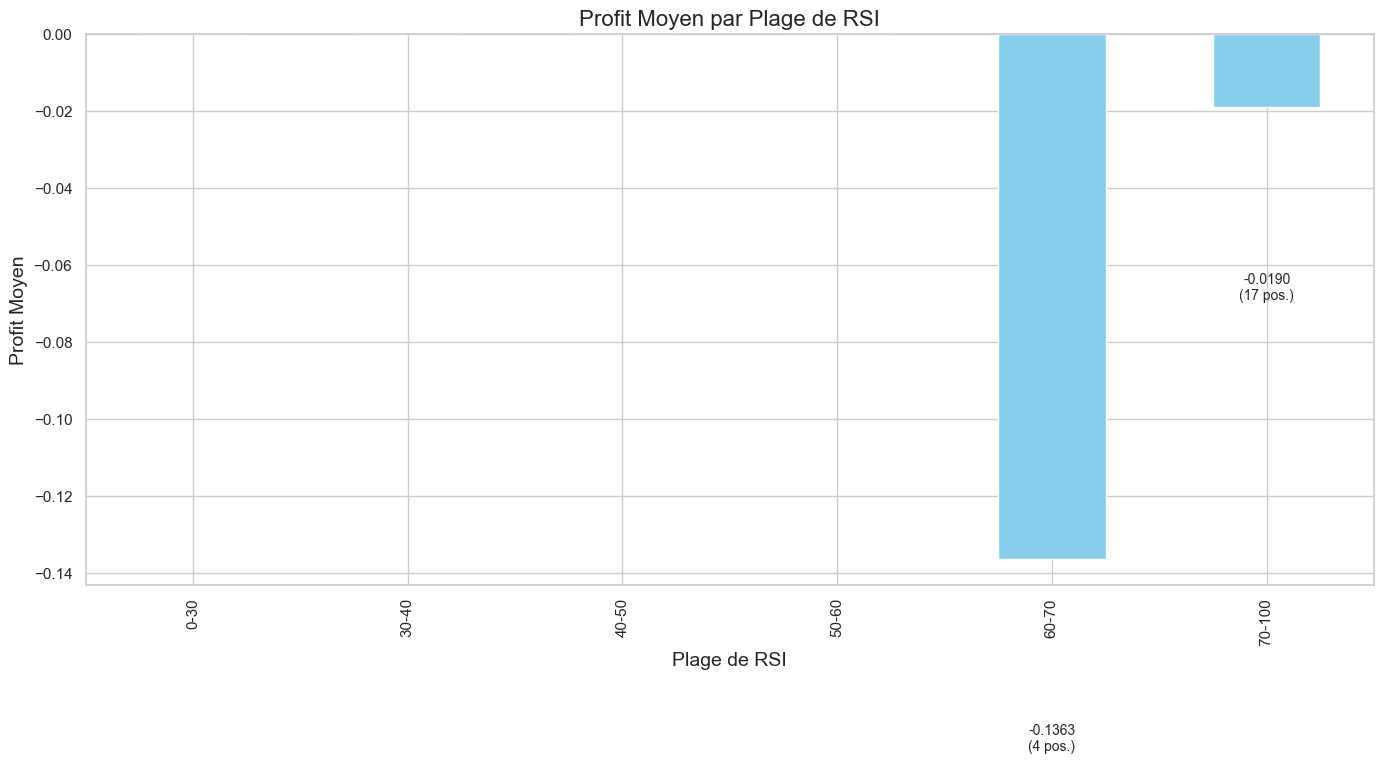

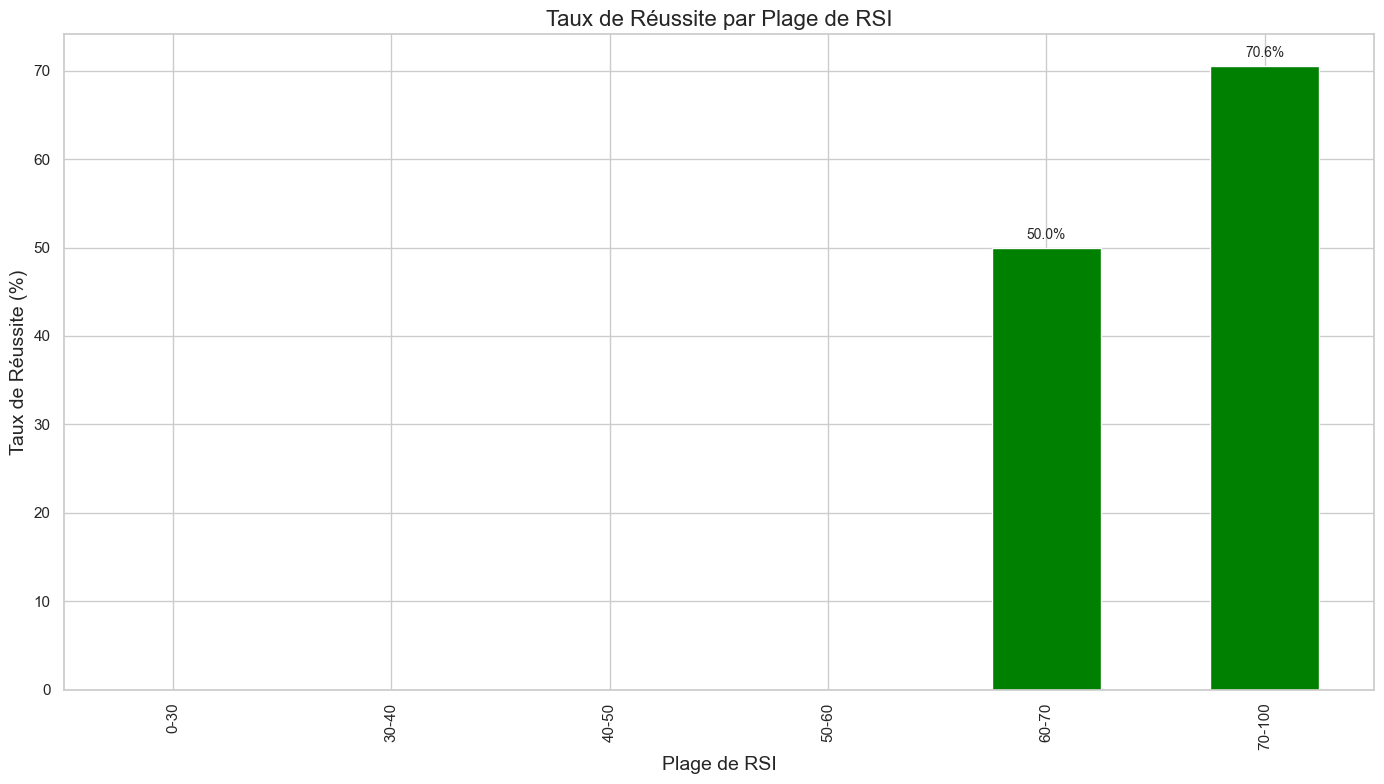

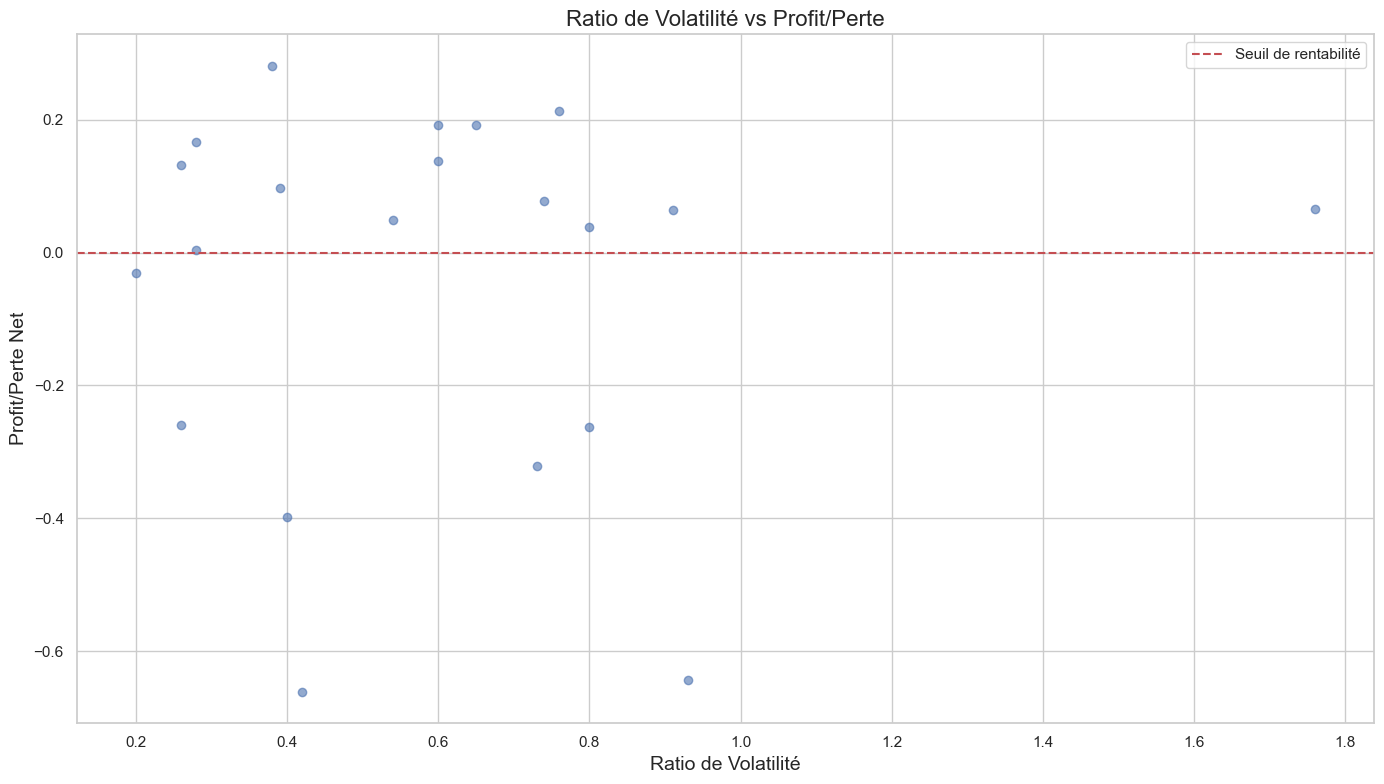

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:331: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_stats = closed_positions.groupby('Volatility_Range')['Profit_Loss_Net'].agg(['mean', 'count'])
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:332: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_stats['win_rate'] = closed_positions.groupby('Volatility_Range')['Profit_Loss_Net'].apply(
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:345: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

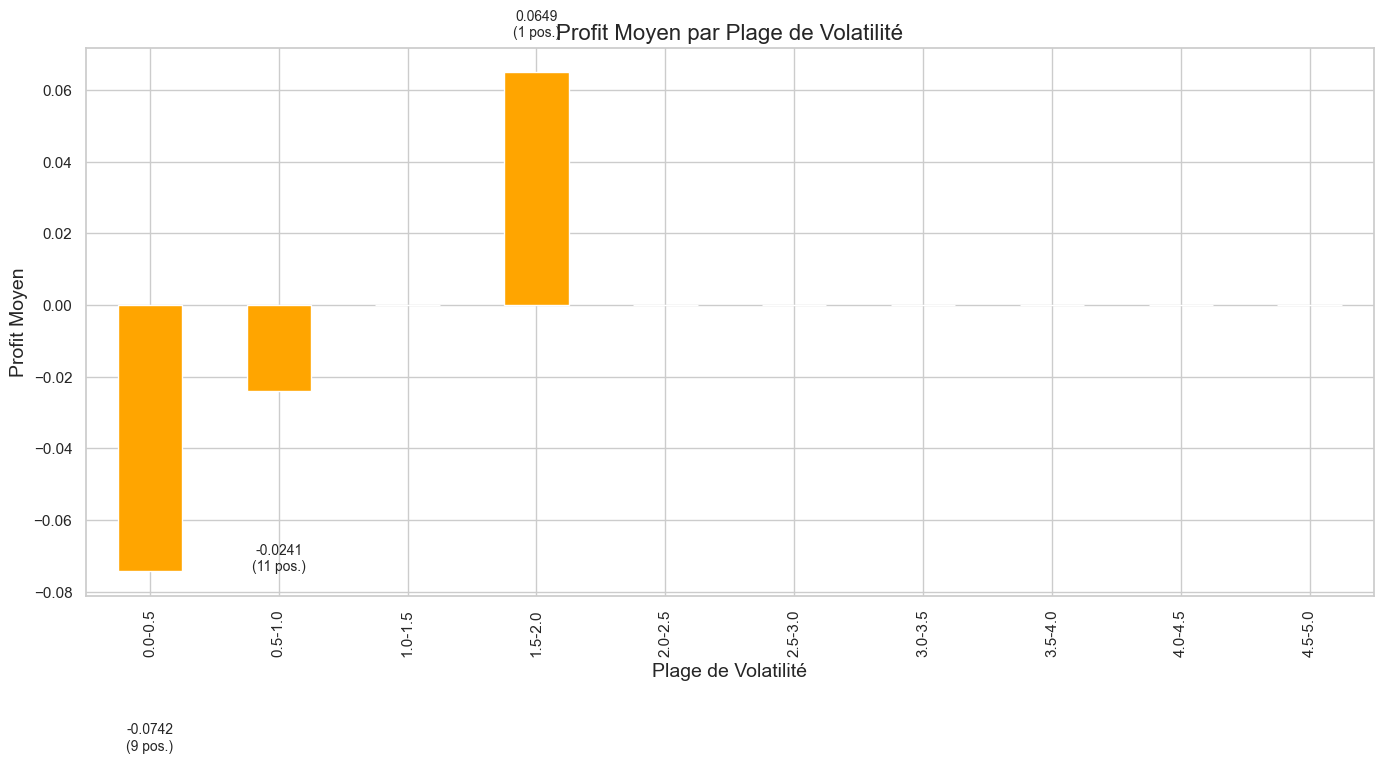

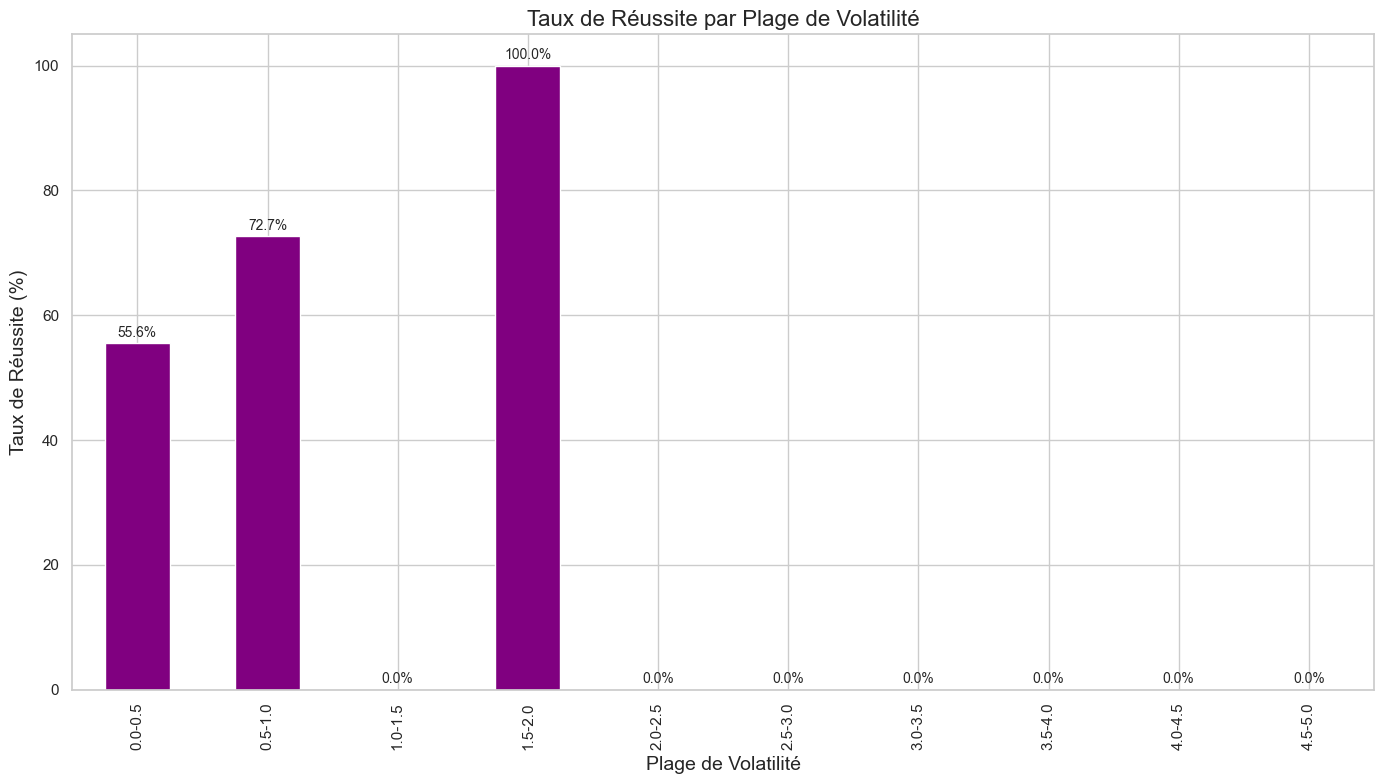

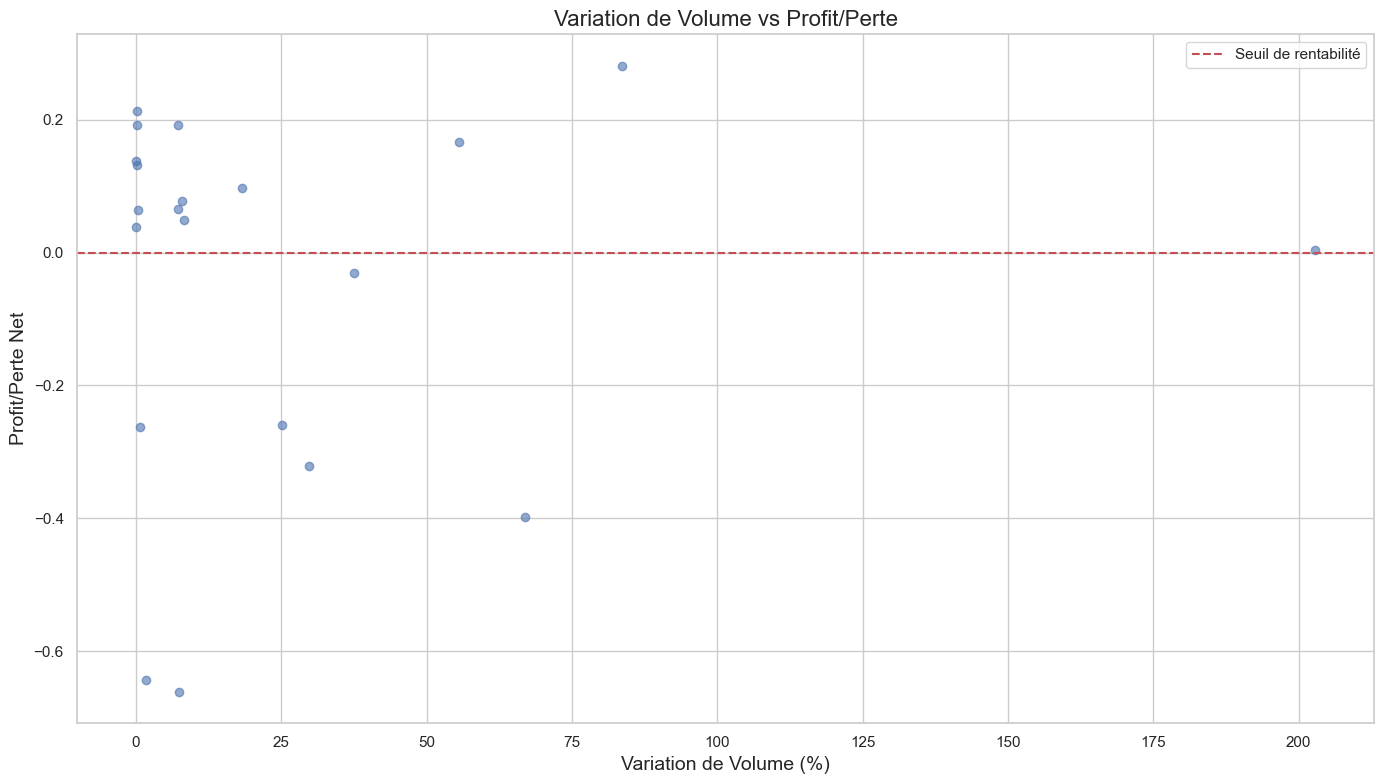

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:394: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_var_stats = closed_positions.groupby('Volume_Variation_Range')['Profit_Loss_Net'].agg(['mean', 'count'])
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:395: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_var_stats['win_rate'] = closed_positions.groupby('Volume_Variation_Range')['Profit_Loss_Net'].apply(
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:408: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, intege

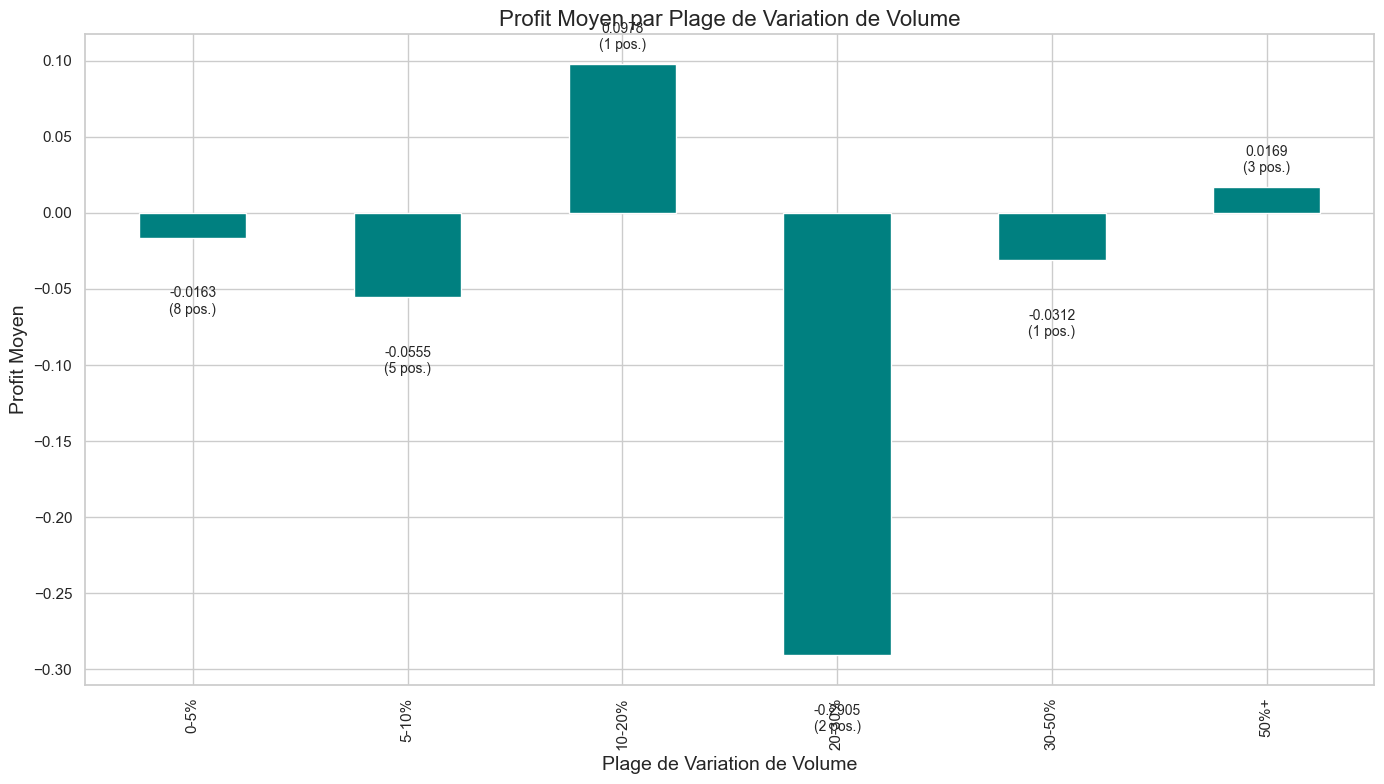

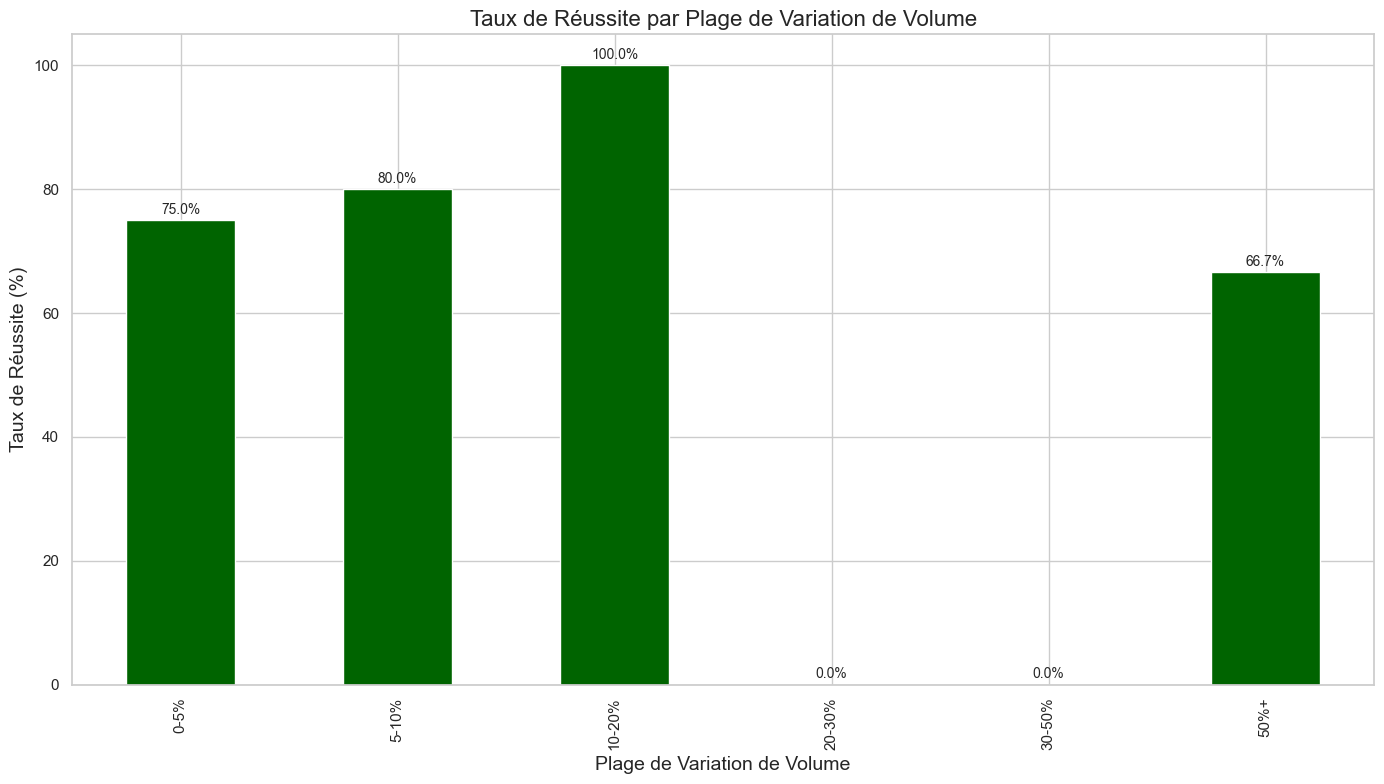

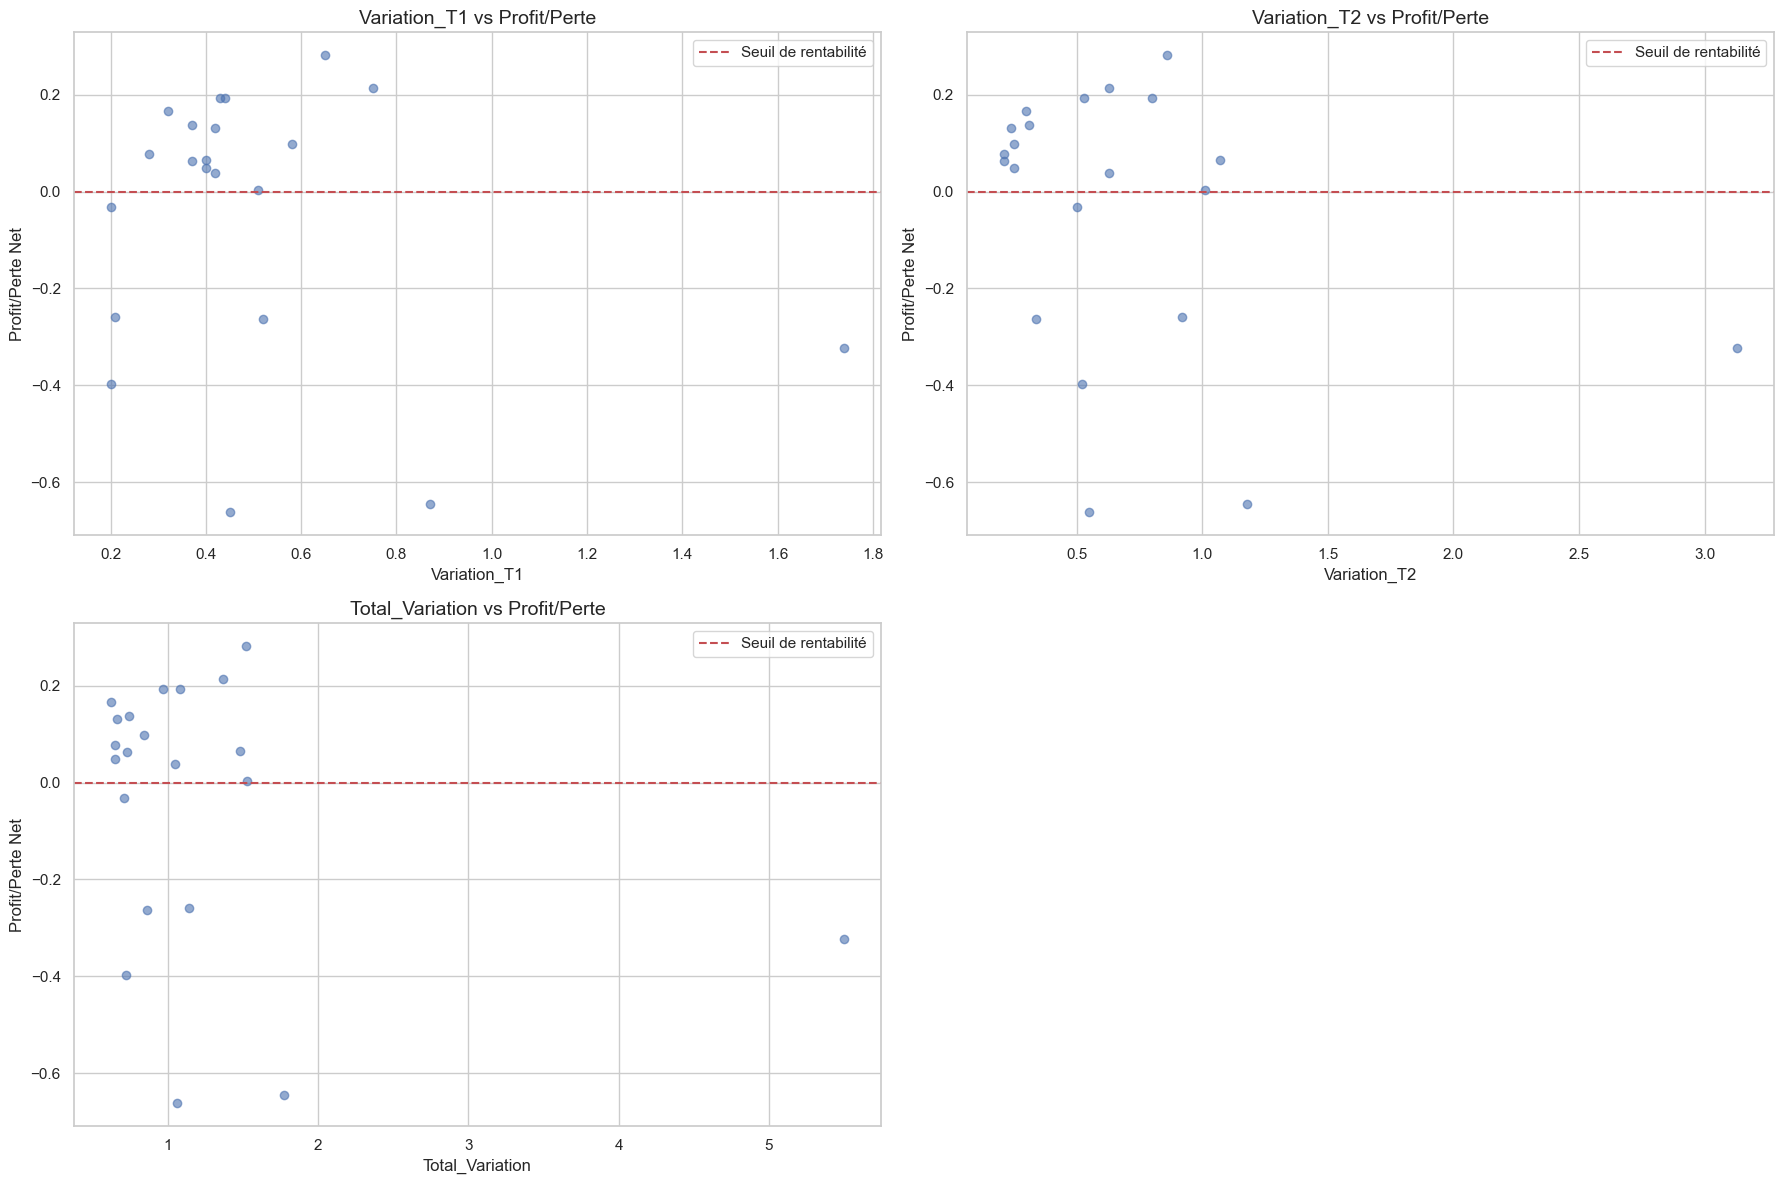

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:527: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_profit = closed_positions.pivot_table(
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:534: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_count = closed_positions.pivot_table(


<Figure size 1400x1000 with 0 Axes>

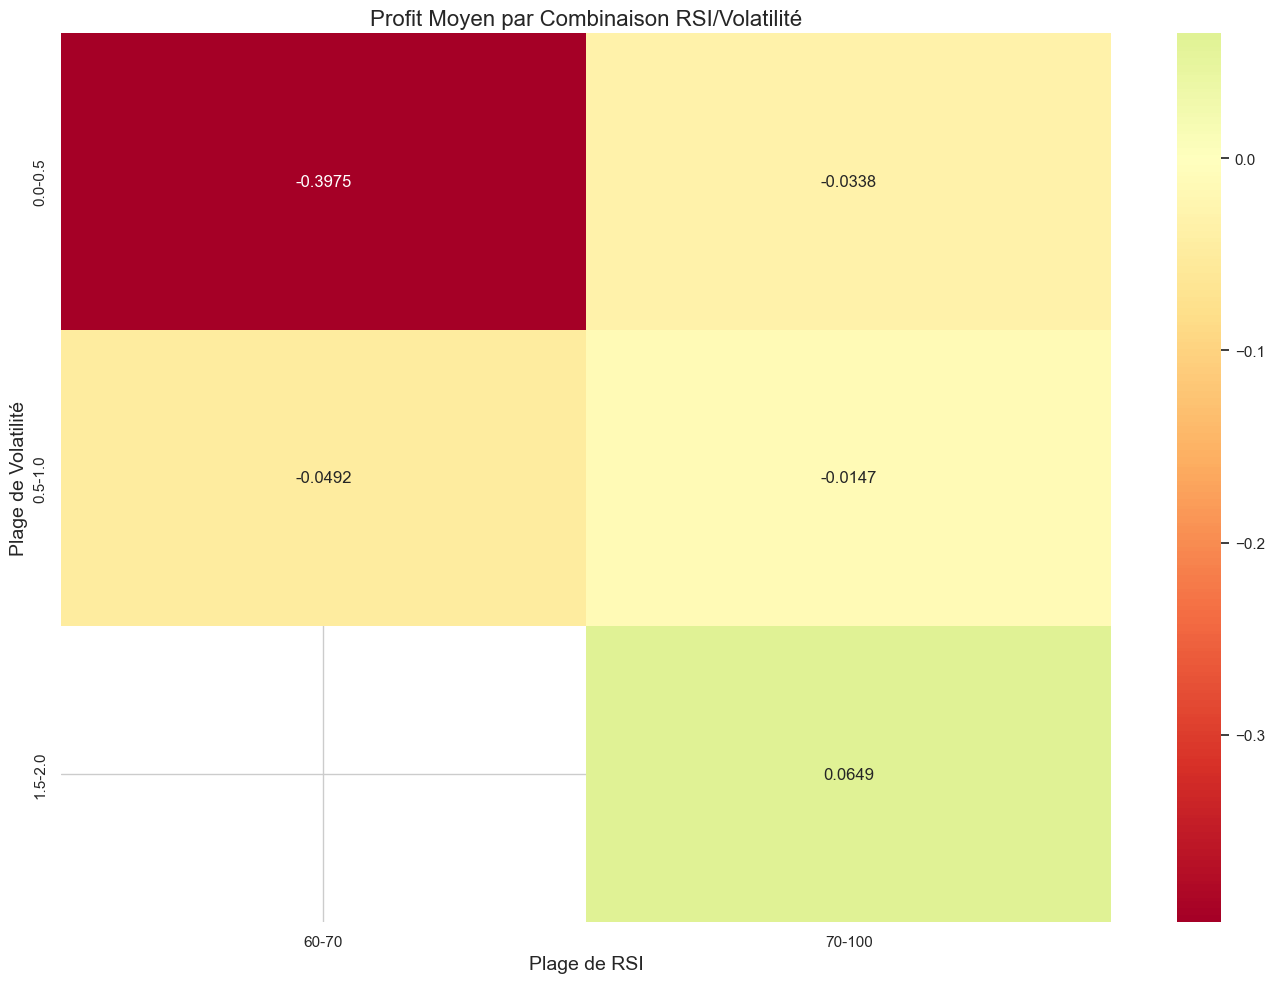

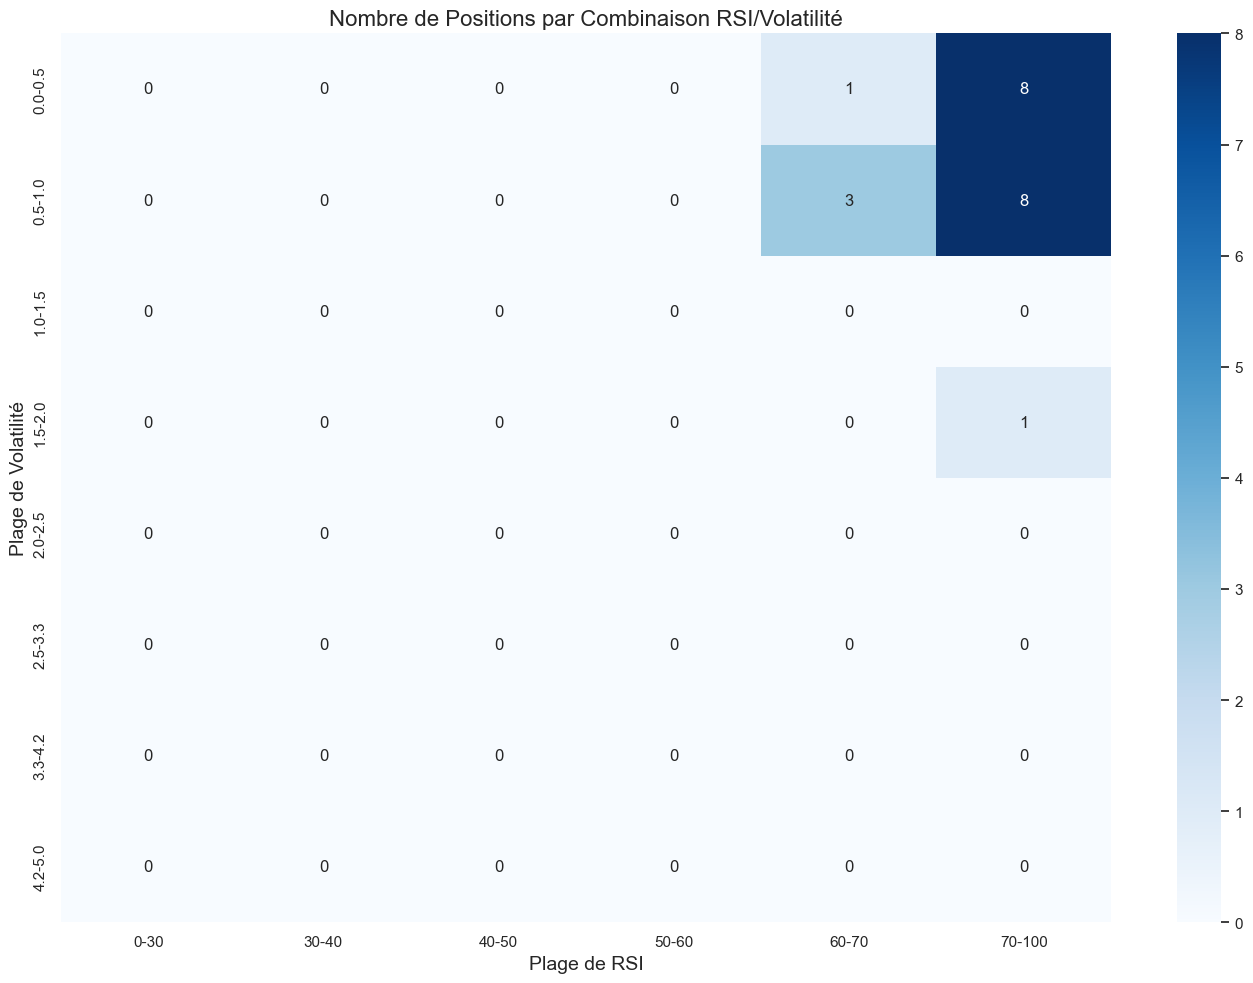

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:563: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_winrate = closed_positions.pivot_table(


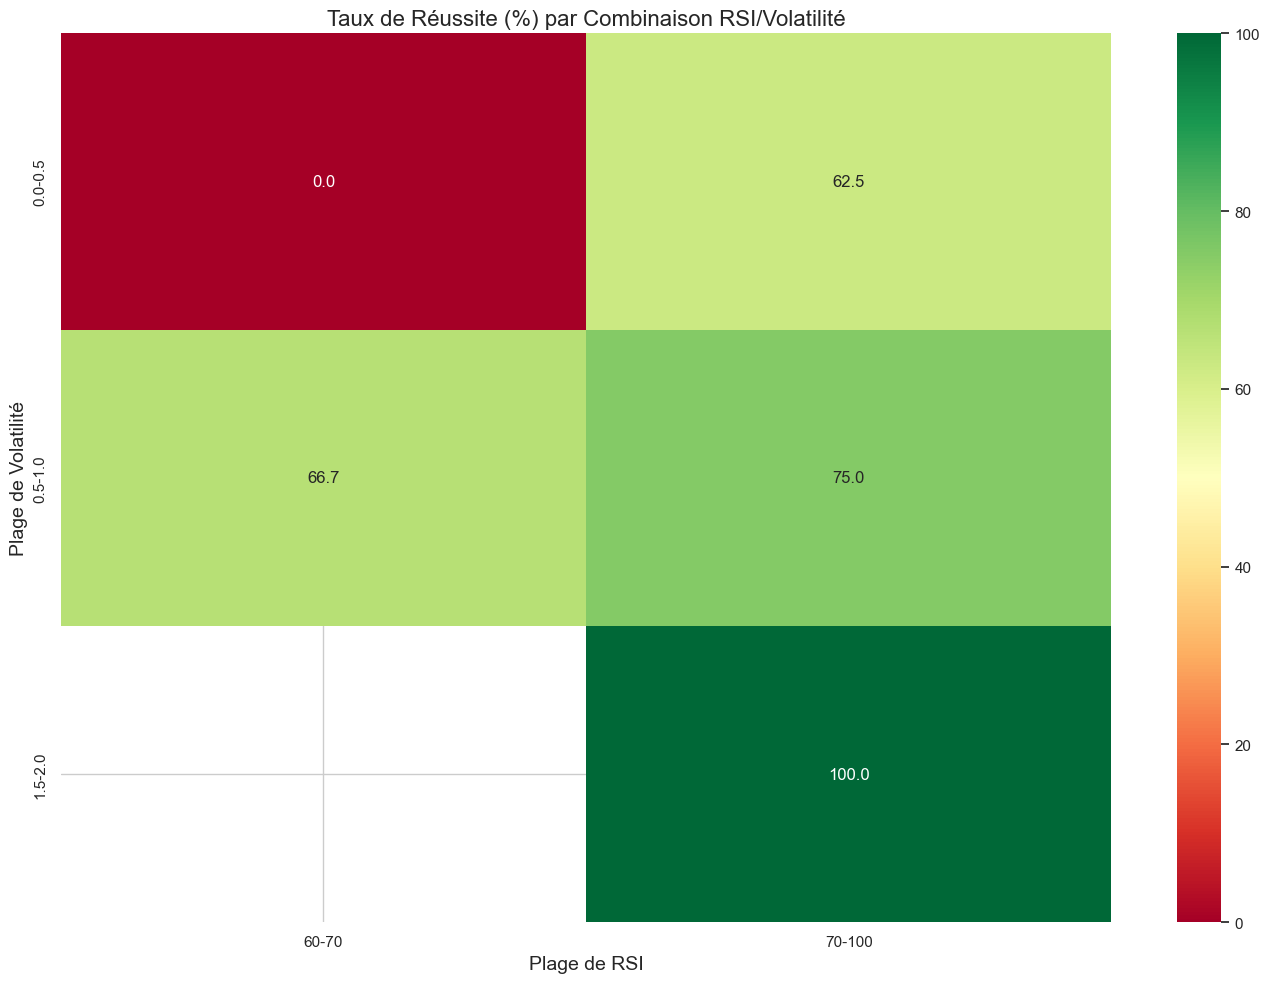

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:581: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_profit_vol = closed_positions.pivot_table(
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:588: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_count_vol = closed_positions.pivot_table(


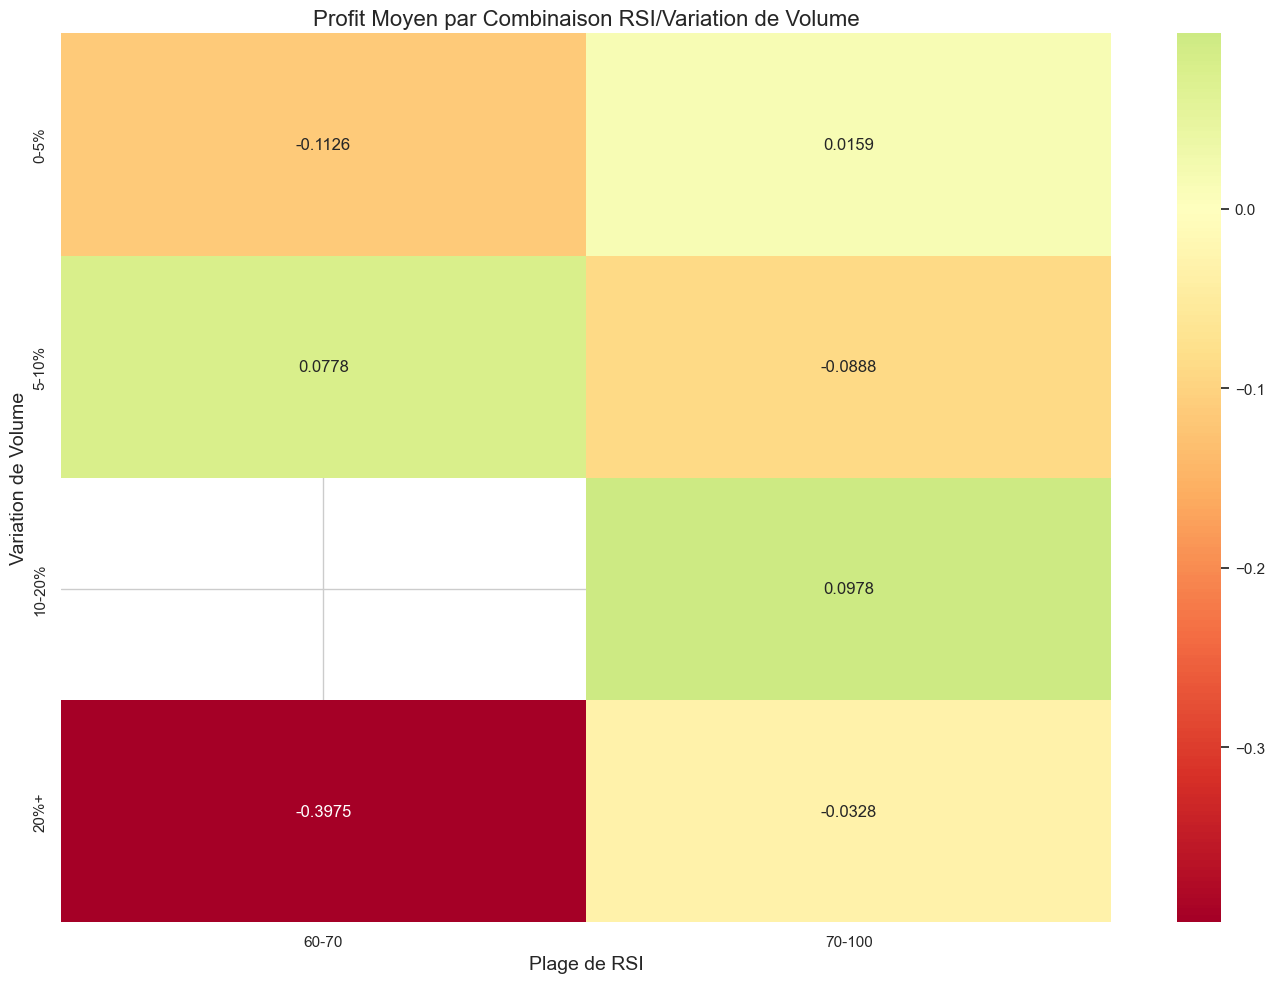

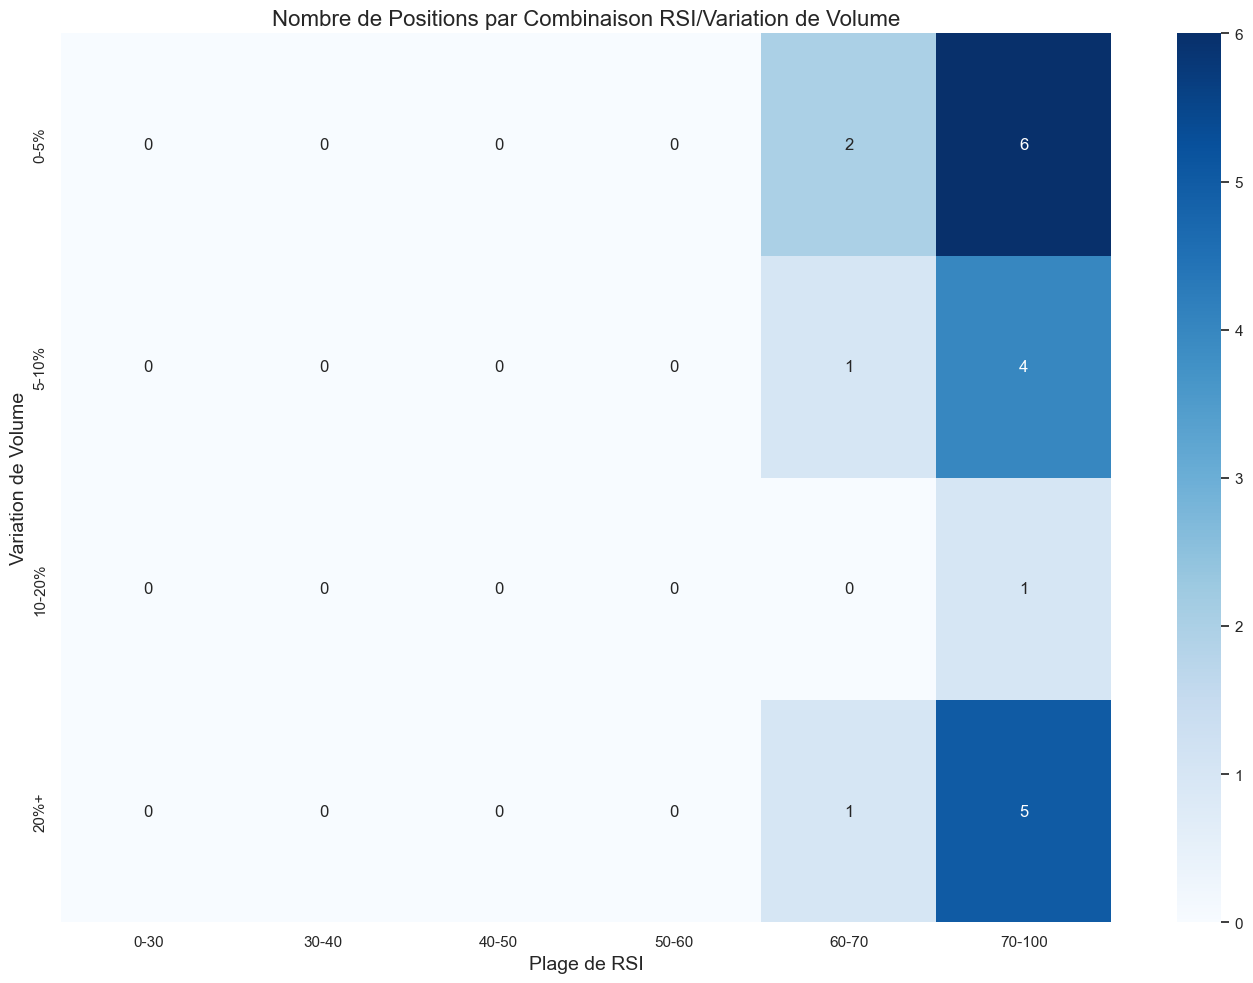

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:614: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_winrate_vol = closed_positions.pivot_table(


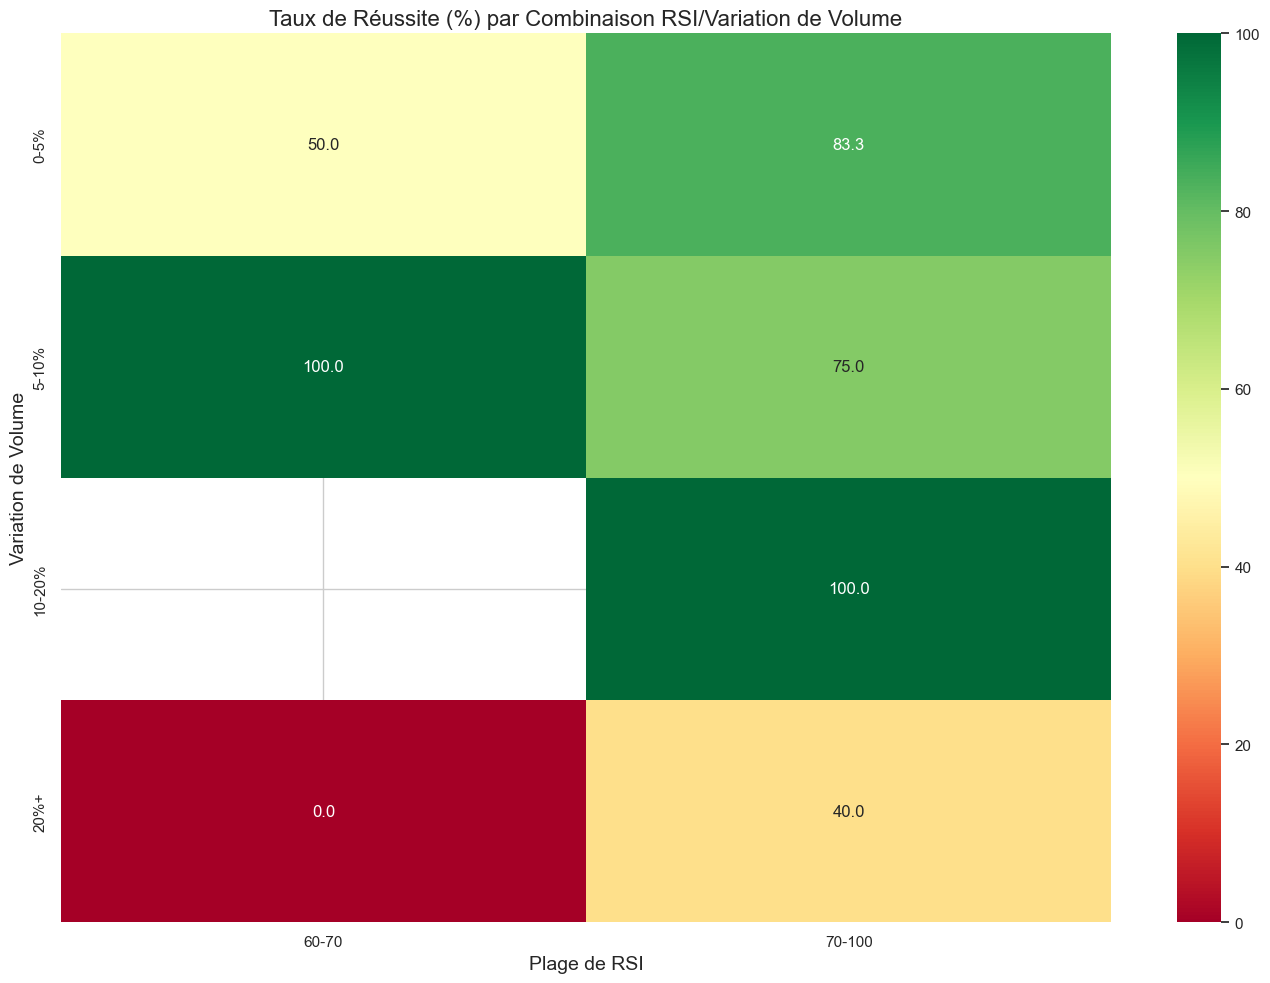

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:632: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_profit_vol_vola = closed_positions.pivot_table(
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:639: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_count_vol_vola = closed_positions.pivot_table(


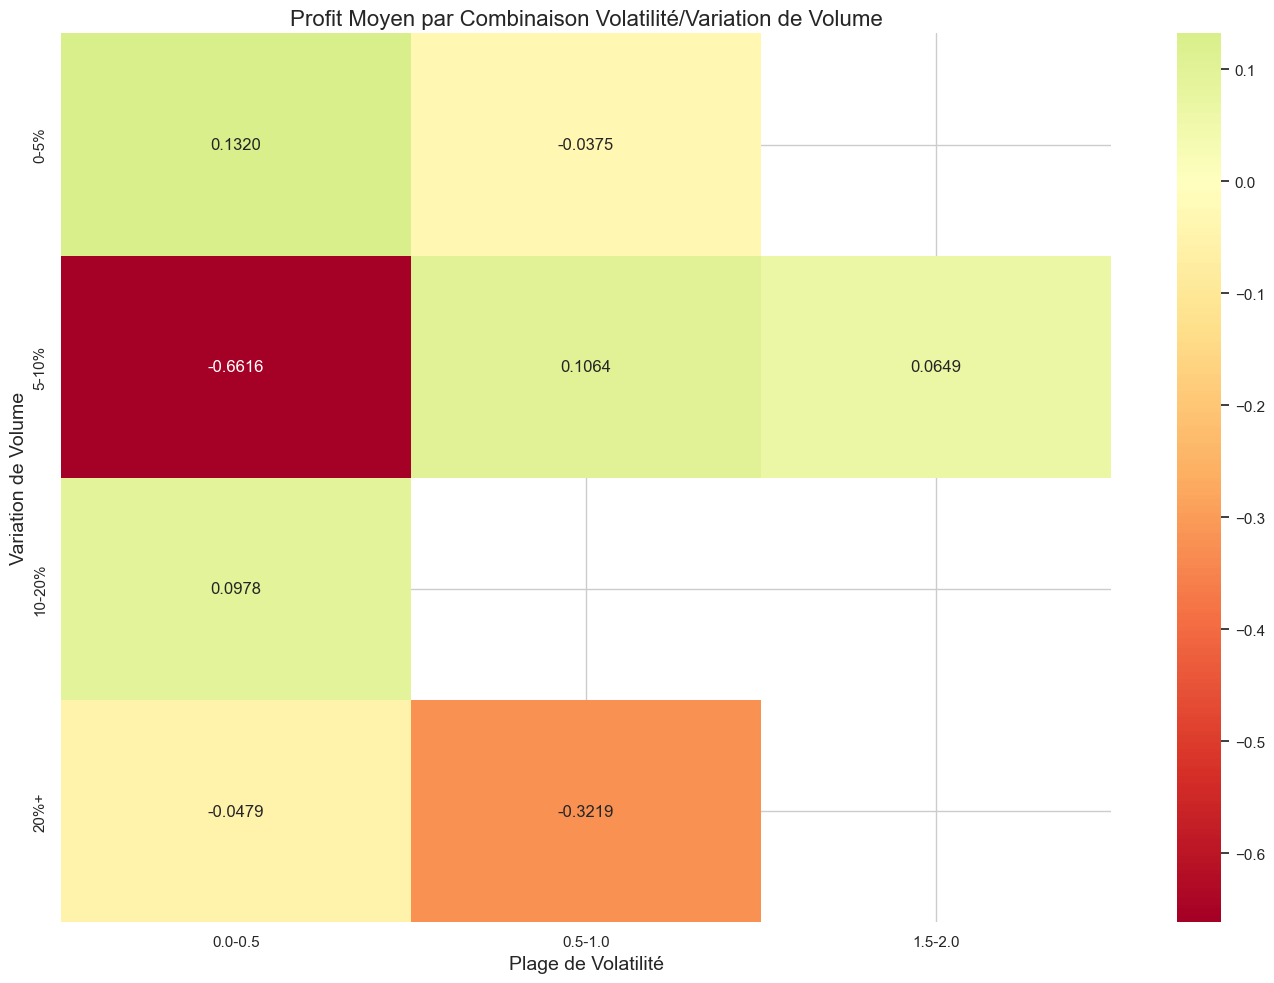

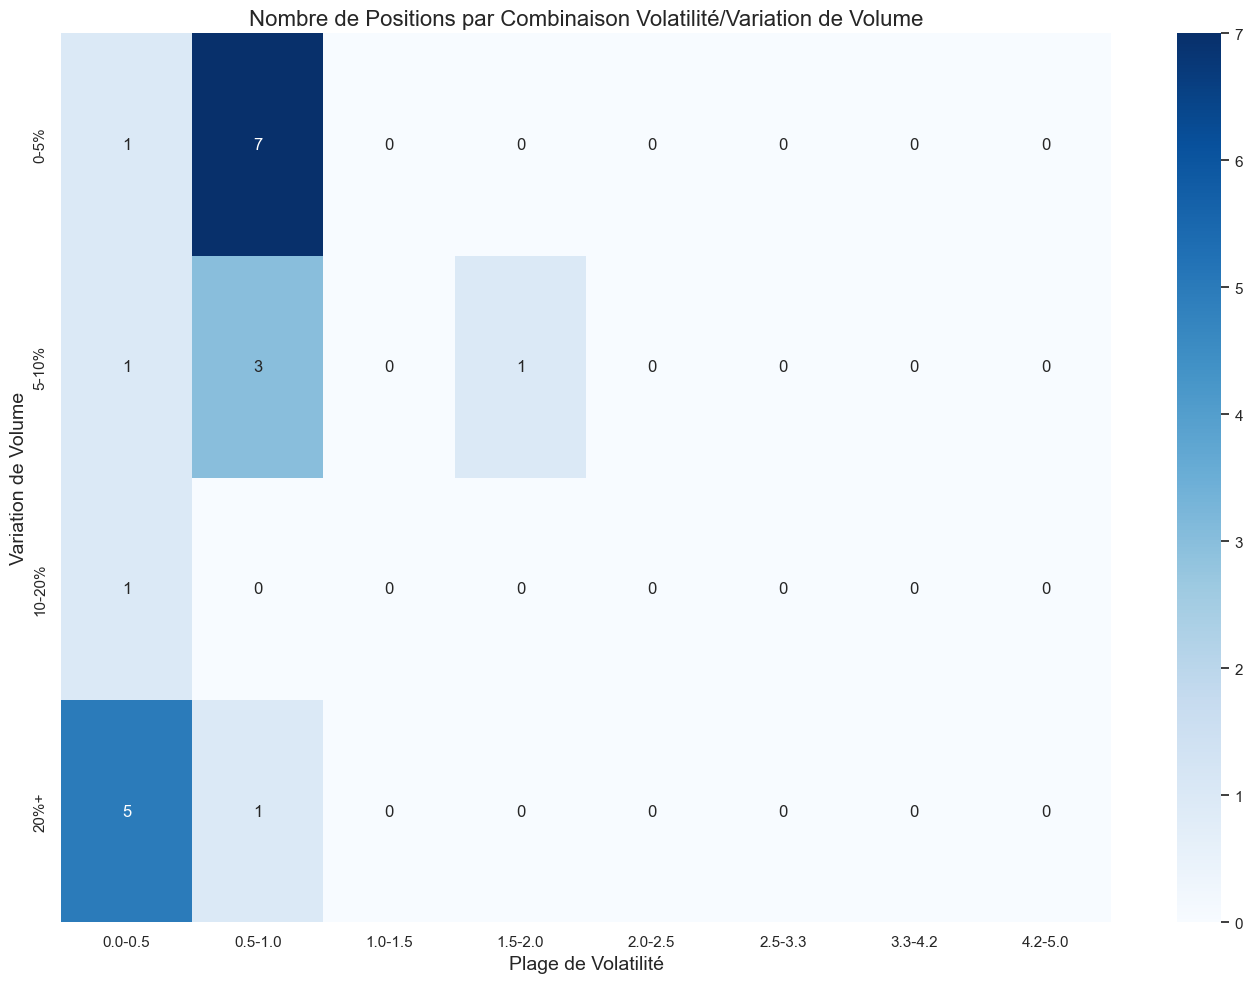

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:665: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_winrate_vol_vola = closed_positions.pivot_table(


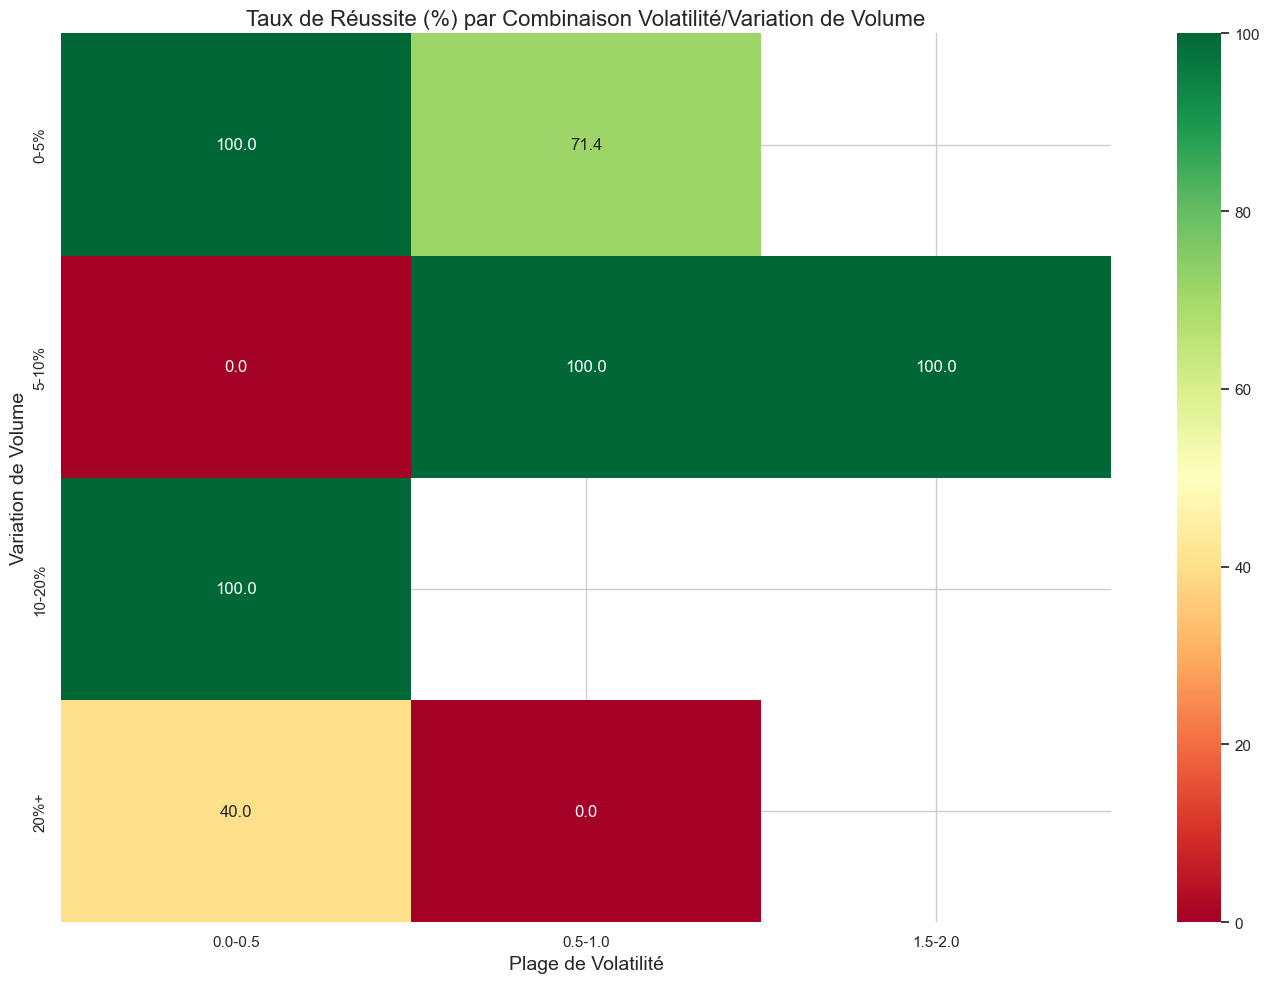

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:685: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_groups = closed_positions.groupby(['RSI_Range', 'Volatility_Range', 'Volume_Variation_Range'])
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:733: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_type = positions_by_type.pivot_table(


=== TOP 10 COMBINAISONS PAR PROFIT MOYEN ===
RSI: 70-100 | Volatilité: 0.0-0.5 | Variation Volume: 0-5% | Profit moyen: 0.1320 | Positions: 1 | Taux de réussite: 100.0%
RSI: 70-100 | Volatilité: 0.5-1.0 | Variation Volume: 5-10% | Profit moyen: 0.1207 | Positions: 2 | Taux de réussite: 100.0%
RSI: 70-100 | Volatilité: 0.0-0.5 | Variation Volume: 10-20% | Profit moyen: 0.0978 | Positions: 1 | Taux de réussite: 100.0%
RSI: 60-70 | Volatilité: 0.5-1.0 | Variation Volume: 5-10% | Profit moyen: 0.0778 | Positions: 1 | Taux de réussite: 100.0%
RSI: 70-100 | Volatilité: 1.5-2.0 | Variation Volume: 5-10% | Profit moyen: 0.0649 | Positions: 1 | Taux de réussite: 100.0%
RSI: 70-100 | Volatilité: 0.0-0.5 | Variation Volume: 20%+ | Profit moyen: 0.0395 | Positions: 4 | Taux de réussite: 50.0%
RSI: 70-100 | Volatilité: 0.5-1.0 | Variation Volume: 0-5% | Profit moyen: -0.0074 | Positions: 5 | Taux de réussite: 80.0%
RSI: 60-70 | Volatilité: 0.5-1.0 | Variation Volume: 0-5% | Profit moyen: -0.1126 | 

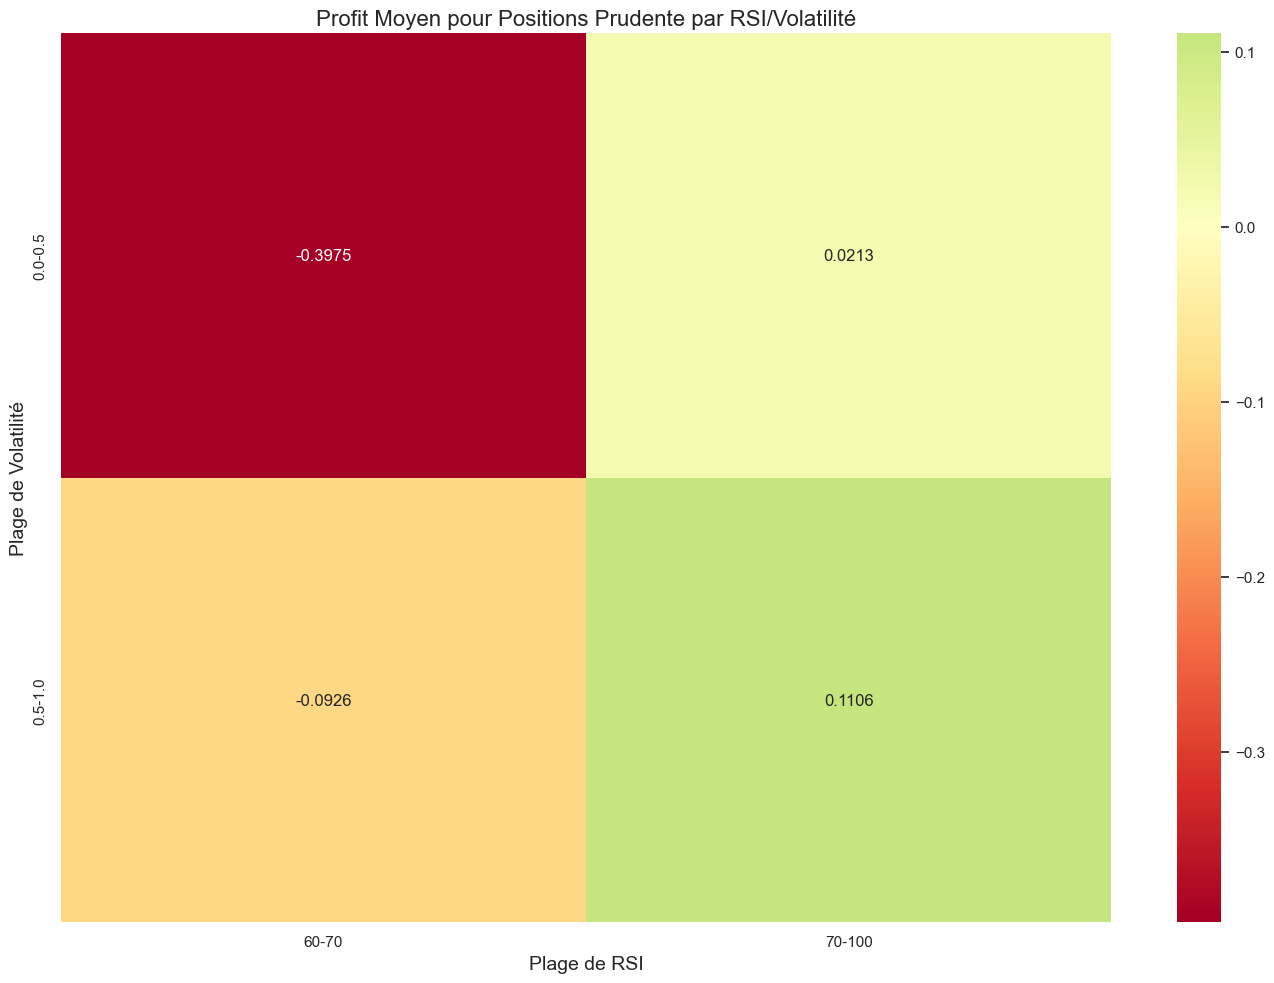

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:750: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_winrate_type = positions_by_type.pivot_table(


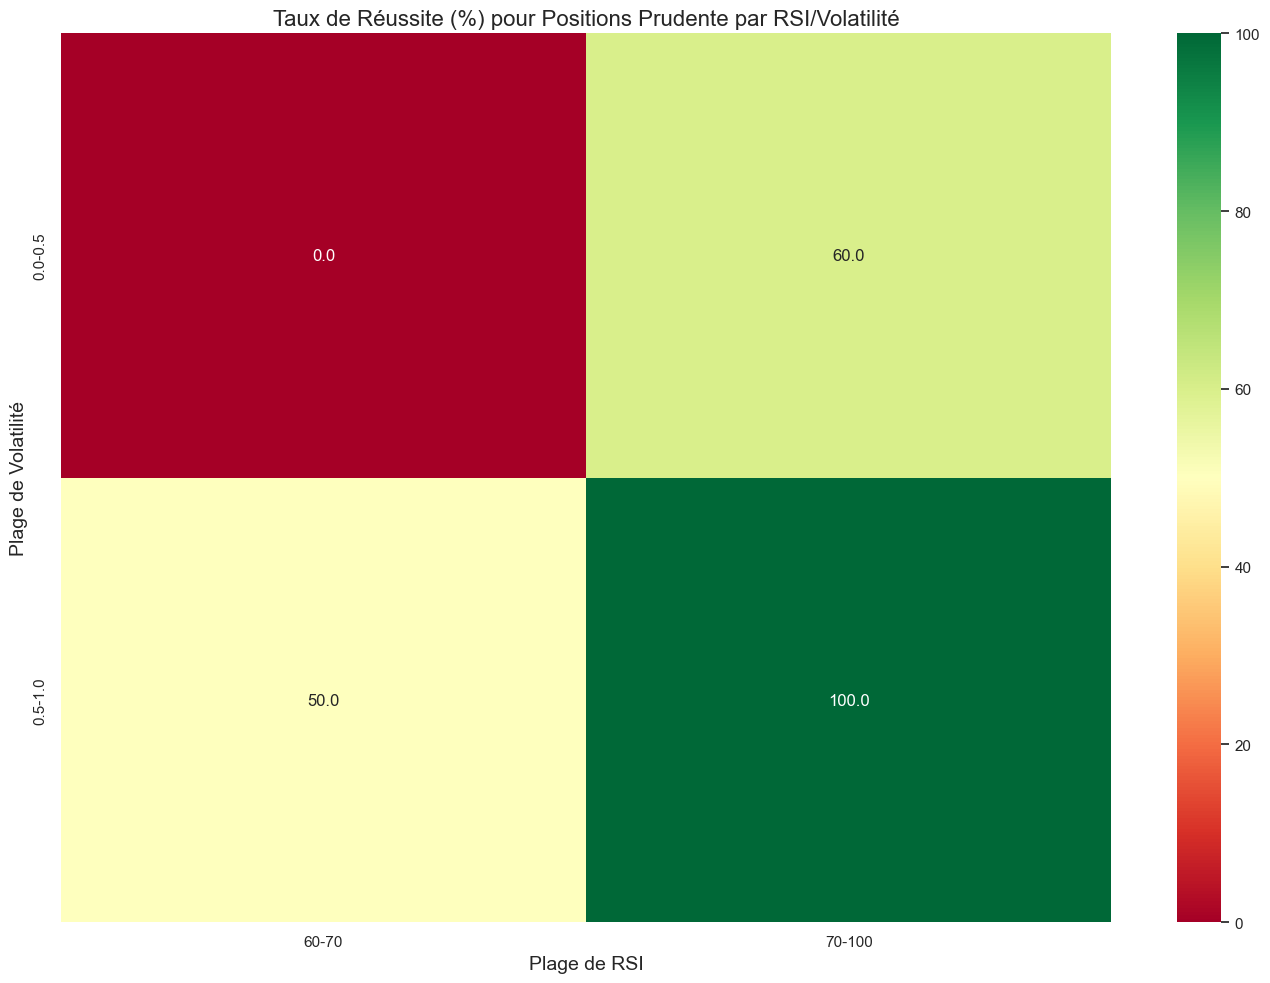

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:733: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_type = positions_by_type.pivot_table(


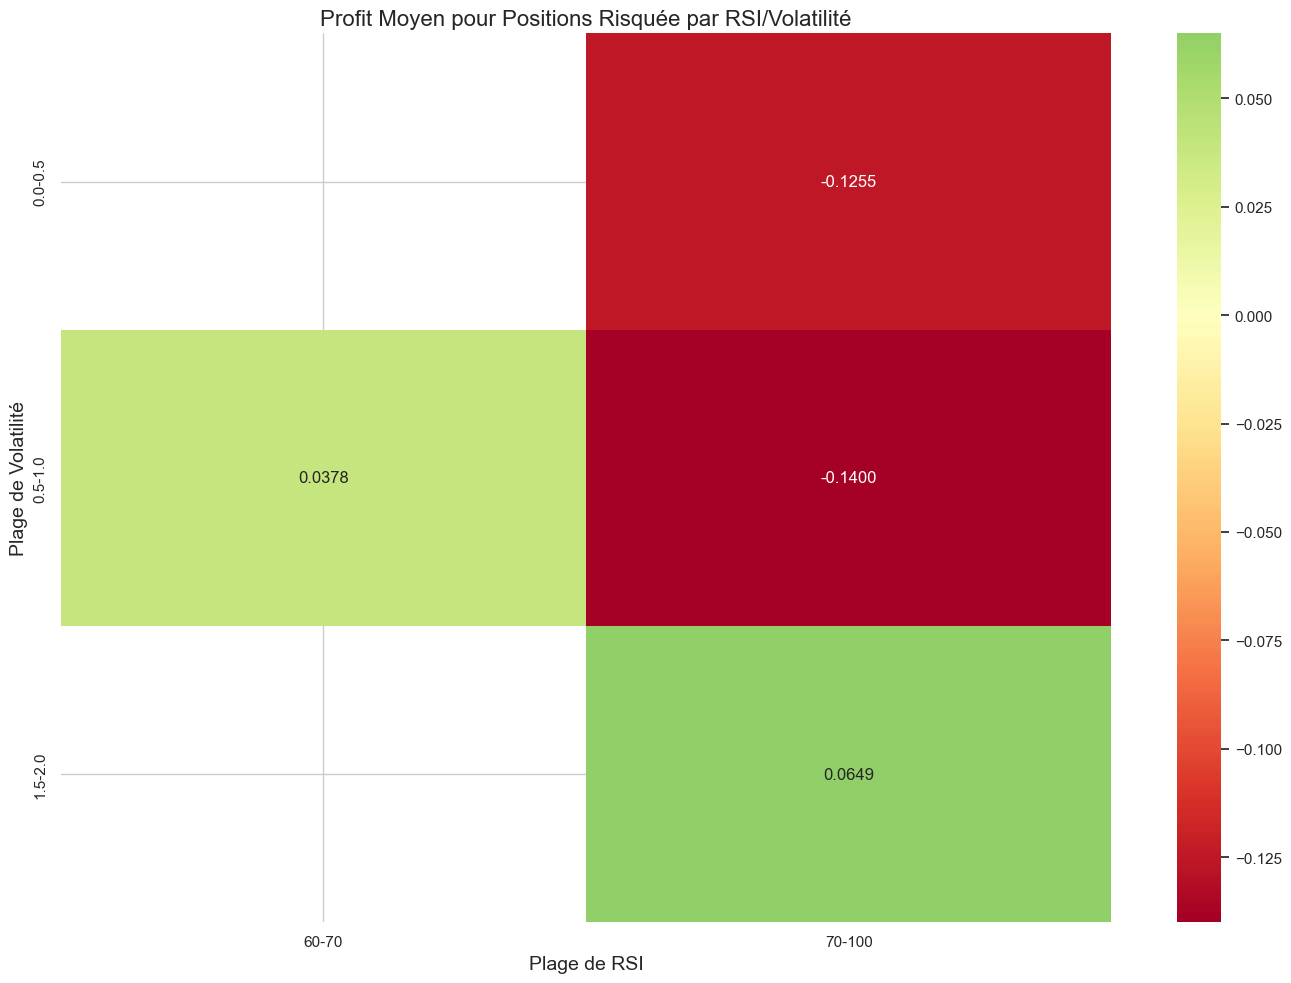

C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:750: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_winrate_type = positions_by_type.pivot_table(


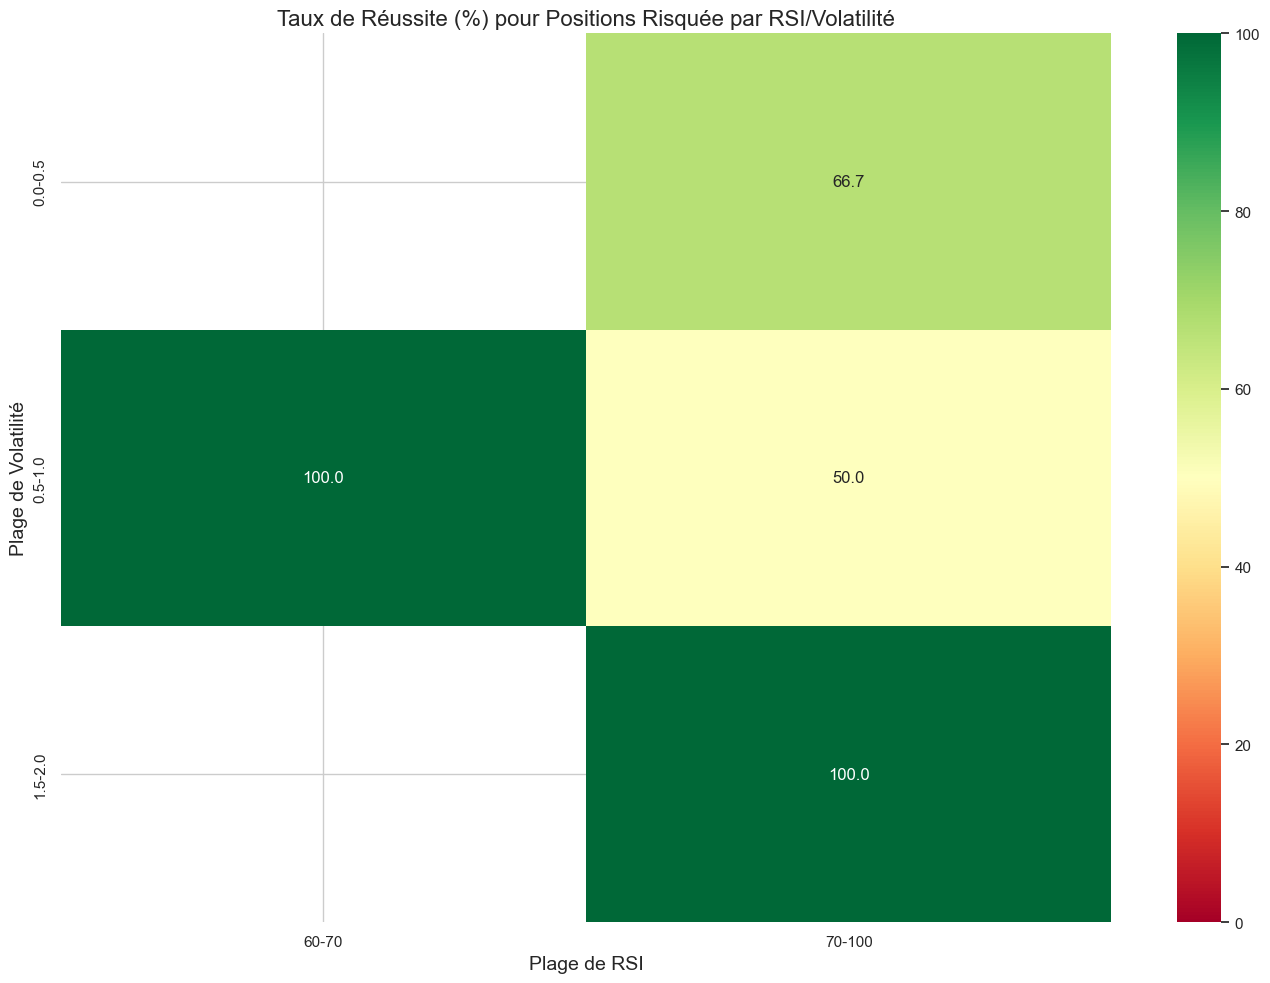

Rapport généré avec succès dans ./rapport\rapport_performance.txt


C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:814: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_stats = closed_positions.groupby('Volatility_Range')['Profit_Loss_Net'].mean()
C:\Users\jtive\AppData\Local\Temp\ipykernel_10616\3472373007.py:825: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rsi_stats = closed_positions.groupby('RSI_Range')['Profit_Loss_Net'].mean()


In [4]:
# Exemple d'utilisation
if __name__ == "__main__":
    # Chemins des fichiers
    crypto_prices_path = 'crypto_prices.csv'
    positions_path = 'positions.csv'
    
    # Créer l'analyseur avec le capital initial correct
    analyzer = TradingAnalyzer(crypto_prices_path, positions_path, initial_capital=100.0)
    
    # Exécuter les analyses améliorées
    analyzer.summary_stats()
    analyzer.analyze_capital_evolution()
    analyzer.analyze_profits_distribution()
    analyzer.analyze_indicators()
    analyzer.analyze_variations()
    analyzer.analyze_combined_indicators()
    analyzer.generate_comprehensive_report()